# King County Project

## Business Problem

A client in King County, WA wants to advise homeowners on **home improvement projects** that will **add to the sale value of their homes**.

**This advice should be based on data from the most recent full calendar year, 2019**.

### Sample Questions:
Enclosing a porch will increase the sale price of a home.

Converting a garage to a bedroom is a good way to increase the sale price of a home.

Upgrading to a forced-air heating system will increase the sale price of a home.

### Core Goals:
Create model

Interpret results

Make recomendations

# Initial EDA Work

### Importing Libraries and Adjusting Settings

In [1]:
# import modules for eda and plotting
import pandas as pd
import numpy as np
import scipy.stats as stats

import sqlite3

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer


import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

import functions as fn

# setting plots to inline
%matplotlib inline

# setting the max number of rows displayed
pd.options.display.max_rows = 300

## SQL Dataframe

### SQL Prelim Work

#### Created Database
Earlier, wrote up a [DB Creator](DB_Creator.ipynb) notebook and ran it to create an SQL database from the raw `.csv` files.

#### Creating DataFrame From the Database

Connecting to the database, and creating a cursor object. Joining the database tables into a second main data frame. Lastly, checking basic information about the data frame.

In [2]:
# creating database, connection, and cursor
conn = sqlite3.connect('KingDB.db')  
cur = conn.cursor()

In [3]:
# checking the table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fn.fetch(cur, q)

[('LOOK',), ('PARC',), ('RESB',), ('SALES',)]

### Joining Tables to Create the Main Data Frame

In [4]:
# joining tables to create dataframe and appending column names
q = """SELECT*FROM SALES AS SA
       JOIN PARC AS PA
       ON SA.Major = PA.Major
       AND SA.Minor = PA.Minor
       JOIN RESB AS RE
       ON PA.Major = RE.Major
       AND PA.Minor = RE.Minor
       """
df = pd.DataFrame(fn.fetch(cur, q))
df.columns = [i[0] for i in cur.description]

In [5]:
# checking info, shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251300 entries, 0 to 251299
Columns: 156 entries, ExciseTaxNbr to AddnlCost
dtypes: object(156)
memory usage: 299.1+ MB


In [6]:
df.shape

(251300, 156)

### Creating the Lookup Data Frame

In [7]:
# joining tables to create dataframe and appending column names
q = """SELECT*FROM LOOK"""
look = pd.DataFrame(fn.fetch(cur, q))
look.columns = [i[0] for i in cur.description]

#### Checking the Lookup Data Frame

Getting basic info, checking the first row, description strings, and cleaning the columns.

In [8]:
# getting info for lookup data frame
look.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LUType         1208 non-null   object
 1   LUItem         1208 non-null   object
 2   LUDescription  1208 non-null   object
dtypes: object(3)
memory usage: 28.4+ KB


In [9]:
# checking first row
look.head(1)

,LUType,LUItem,LUDescription
0,1,1,LAND ONLY ...


In [10]:
# checking strings
look.LUType.values[:2], look.LUItem.values[:2], look.LUDescription.values[:2]

(array(['1  ', '1  '], dtype=object),
 array(['1  ', '10 '], dtype=object),
 array(['LAND ONLY                                         ',
        'Land with new building                            '], dtype=object))

Cleaning strings and checking results.

In [11]:
# cleaning strings
look['LUType'] = fn.col_stripper(look, 'LUType')
look['LUItem'] = fn.col_stripper(look, 'LUItem')
look['LUDescription'] = fn.col_stripper(look, 'LUDescription')

In [12]:
# checking results
print(look.LUType.values)
print(look.LUItem.values)
look.LUDescription.values

['1' '1' '1' ... '99' '99' '99']
['1' '10' '11' ... '3' '4' '5']


array(['LAND ONLY', 'Land with new building',
       'Household, single family units', ..., 'AVERAGE', 'ABOVE AVERAGE',
       'EXCELLENT'], dtype=object)

### Checking & Dealing with Columns in Main Data Frame
Working through the columns of the main data frame to narrow down the list of features to a more manageable size.

In [13]:
# checking columns
list(df.columns)

['ExciseTaxNbr',
 'Major',
 'Minor',
 'DocumentDate',
 'SalePrice',
 'RecordingNbr',
 'Volume',
 'Page',
 'PlatNbr',
 'PlatType',
 'PlatLot',
 'PlatBlock',
 'SellerName',
 'BuyerName',
 'PropertyType',
 'PrincipalUse',
 'SaleInstrument',
 'AFForestLand',
 'AFCurrentUseLand',
 'AFNonProfitUse',
 'AFHistoricProperty',
 'SaleReason',
 'PropertyClass',
 'SaleWarning',
 'Unnamed: 0',
 'Major',
 'Minor',
 'PropName',
 'PlatName',
 'PlatLot',
 'PlatBlock',
 'Range',
 'Township',
 'Section',
 'QuarterSection',
 'PropType',
 'Area',
 'SubArea',
 'SpecArea',
 'SpecSubArea',
 'DistrictName',
 'LevyCode',
 'CurrentZoning',
 'HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse',
 'SqFtLot',
 'WaterSystem',
 'SewerSystem',
 'Access',
 'Topography',
 'StreetSurface',
 'RestrictiveSzShape',
 'InadequateParking',
 'PcntUnusable',
 'Unbuildable',
 'MtRainier',
 'Olympics',
 'Cascades',
 'Territorial',
 'SeattleSkyline',
 'PugetSound',
 'LakeWashington',
 'LakeSammamish',
 'SmallLakeRiverCreek',
 'OtherView',

#### Removing `Unnamed: 0` Column

In [14]:
# using custom dropper function to remove unnamed column found above
fn.dropper(df, ['Unnamed: 0'], True)

## Checking `PropertyType`, `PropertyClass`, `PropType`


In [15]:
df[['PropertyType', 'PropertyClass', 'PropType']].head(3)

,PropertyType,PropertyClass,PropType
0,3,8,R
1,2,8,R
2,3,8,R


Checking Lookup Codes

In [16]:
fn.lookup(look, 1), fn.lookup(look,4)

(   LUType LUItem                                      LUDescription
 0       1      1                                          LAND ONLY
 1       1     10                             Land with new building
 2       1     11                     Household, single family units
 3       1     12  Multiple family residence (Residential, 2-4 un...
 4       1     13  Multiple family residence (Residential, 5+ units)
 5       1     14                           Residential condominiums
 6       1     15                        Mobile home parks or courts
 7       1     16                                      Hotels/motels
 8       1     17                              Institutional lodging
 9       1     18          All other residential not elsewhere coded
 10      1     19                                 Vacation and cabin
 11      1      2                             LAND WITH NEW BUILDING
 12      1     21                          Food and kindred products
 13      1     22                 

#### Making `PropType` Lookup Data Frame

In [17]:
# PropType Codes 
codes = ['C', 'K', 'M', 'N', 'R', 'T', 'U', 'X']
ptypes = ['Commercial', 'Condominium', 'Coal & Mineral Rights',\
            'Mining', 'Residential', 'Timber', 'Undivided Interest', 'Exempt']
pt = {'LUItem': codes, 'LUDescription': ptypes}
PropTypes = pd.DataFrame().from_dict(pt)
PropTypes

,LUItem,LUDescription
0,C,Commercial
1,K,Condominium
2,M,Coal & Mineral Rights
3,N,Mining
4,R,Residential
5,T,Timber
6,U,Undivided Interest
7,X,Exempt


In [18]:
df.groupby('PropertyType').size().sort_values(ascending=False)

PropertyType
3     138077
11     88244
2      11250
1       5351
10      4256
0       1285
12       741
91       590
14       478
5        336
4        209
18        72
13        68
99        54
6         41
45        41
94        37
59        37
96        31
83        20
19        14
80         8
88         7
9          7
95         5
65         5
17         4
69         3
47         3
15         2
50         2
21         2
30         2
68         2
76         2
22         2
90         1
93         1
92         1
23         1
44         1
89         1
86         1
24         1
33         1
32         1
51         1
63         1
dtype: int64

## Light Data Cleaning

Changing datestrings to datetime objects,  and sale price strings to floats in the main pandas dataframe. Adding a 'DocumentYear' column to main the data frame.

In [19]:
# changing date strings to datetime objects
df.DocumentDate = pd.to_datetime(df.DocumentDate)

# adding a document year column
df['DocumentYear'] = df['DocumentDate'].apply(lambda x: x.year)

# converting SalePrice string to float
df['SalePrice'] = df['SalePrice'].astype('float')

### Checking For Null Values

In [20]:
# checking nulls and shape
print(df.isna().sum())
df.shape

ExciseTaxNbr                   0
Major                          0
Minor                          0
DocumentDate                   0
SalePrice                      0
RecordingNbr                   0
Volume                         0
Page                           0
PlatNbr                        0
PlatType                       0
PlatLot                        0
PlatBlock                      0
SellerName                     0
BuyerName                      0
PropertyType                   0
PrincipalUse                   0
SaleInstrument                 0
AFForestLand                   0
AFCurrentUseLand               0
AFNonProfitUse                 0
AFHistoricProperty             0
SaleReason                     0
PropertyClass                  0
SaleWarning                    0
Major                          0
Minor                          0
PropName                   11473
PlatName                   29223
PlatLot                        0
PlatBlock                      0
Range     

(251300, 156)

### Checking `'SpecArea'` and `'SpecSubArea'` columns.

In [21]:
# inspecting columns with custom chunker() function
fn.chunker(df, ['SpecArea', 'SpecSubArea'])

,SpecArea,SpecSubArea
0,None,None
1,None,None
2,None,None


It looks like the `'SpecArea'` and `'SpecSubArea'` are extraneous columns for modeling purposes so they will be dropped.

In [22]:
# dropping columns and checking first row
fn.dropper(df, ['SpecArea', 'SpecSubArea'], True)
df.head(1)

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear
0,2743355,638580,0110,2015-07-14,190000.0,20150715002686,,,,,...,0,1,1963,0,0,0,0,3,0,2015


### Inspecting Columns with Null Values

In [23]:
# checking problematic columns
li = ['PropName', 'PlatName', 'DirectionPrefix', 'DirectionSuffix', 'ZipCode']
fn.chunker(df, li)

,PropName,PlatName,DirectionPrefix,DirectionSuffix,ZipCode
0,,OLYMPIC TERRACE ADD,,S,98188
1,None,VINTNER'S PLACE,NE,,None
2,,LAKE UNION ADD,,N,98103


#### Keeping `'ZipCode'` Column but Dropping Others

The othe columns have to do with Plat Mapping and seem irrelevant to the model. Zip Codes can have value as proxy indicators so may be useful later. Keeping for now.

In [24]:
# dropping extraneous columns
fn.dropper(df, li[:4], True)

In [25]:
df[df.isna().any(axis=1)]

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear
1,2841697,894677,0240,2016-12-21,818161.0,20161228000896,,,,,...,0,0,2016,0,0,0,0,3,0,2016
20,2723231,912610,0736,2015-01-30,0.0,20150409000784,,,,,...,0,0,2013,0,0,0,0,3,0,2015
24,2799723,162404,9140,2016-05-18,414950.0,20160601000406,,,,,...,0,0,2016,0,0,0,0,3,0,2016
31,2855775,931550,0560,2017-03-07,608283.0,20170329001482,,,,,...,0,0,2016,0,0,0,0,3,0,2017
39,2862980,418720,0290,2017-05-01,750000.0,,,,,,...,0,0,2010,0,0,0,0,3,6000,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251281,3045715,412700,0898,2020-04-29,619000.0,20200505001286,,,,,...,0,0,2018,0,0,0,0,3,6000,2020
251283,2901247,095200,5840,2017-11-09,0.0,20171116001180,,,,,...,0,0,2017,0,0,0,0,3,0,2017
251290,2997920,302300,0320,2019-05-01,0.0,20190705000539,,,,,...,0,0,2011,0,0,0,0,3,6000,2019
251298,2971374,924600,0650,2019-01-02,0.0,,,,,,...,0,0,2015,0,0,0,0,3,0,2019


In [26]:
# checking number of null zips
df.isna().any(axis=1).sum()

39980

### Replacing Null Zip Codes With `'00000'`

In [27]:
# filling NaNs with '00000'
df.fillna('00000', inplace=True)

In [28]:
# checking work
df['ZipCode'].isna().sum()

0

In [29]:
# checking unique zipcodes
df['ZipCode'].unique()

array(['98188', '00000', '98103', '98115', '98106', '98019', '98038',
       '98070', '98168', '98092', '98125', '98030', '98007', '98116',
       '98023', '98109', '98033', '98146', '98117', '98052', '98058',
       '98045', '98118', '98166', '98034', '98004', '98133', '98006',
       '98002', '98065', '98075', '98010', '98102', '98077', '98011',
       '98074', '98042', '98032', '98053', '98198', '98051', '98001',
       '98008', '98059', '98003', '98027', '98056', '98028', '98126',
       '98107', '98122', '98155', '98105', '98022', '98199', '98136',
       '98040', '98047', '98177', '98031', '98005', '98148', '98108',
       '98178', '98055', '98144', '98112', '98072', '98119', '98029',
       '98024', '98302', '98039', '98288', '98014', '98058 ', '98224',
       '98057', '98354', '98134', '98050', '98104', '98000', '98132',
       '98026', '98204', '98042-3001', '98068', '98023-7330',
       '98074-9301', '98034-2540', '98097', '8126', '9059', '28028',
       'A on plans', '98189'

### Cleaning ZipCode Data
Adding new `ZipClean` column and cleaning zip code data by splitting 9-digit code and dropping last 4 digits. Also, stripping whitespaces and dropping any rows with codes not of length 5. Lastly, dropping original `ZipCode` column.

In [30]:
# adding new column with split codes
df['ZipClean']=df.groupby('ZipCode')['ZipCode'].transform(lambda x: x.str.split('-').str[0])

In [31]:
# stripping whitespace
df['ZipClean'] = fn.col_stripper(df,'ZipClean')

In [32]:
# making a list of uniques
uniques = df['ZipClean'].unique()

In [33]:
# making a list of dirty strings
dirty_zips = [x for x in uniques if len(x) != 5]

In [34]:
# printing list of dirty strings
dirty_zips

['8126',
 '9059',
 'A on plans',
 '',
 '98',
 '988122',
 '981182019',
 '3',
 '9800',
 '9859',
 '9804']

In [35]:
# dropping rows with dirty zip codes
df = df[~df.ZipClean.isin(dirty_zips)]

In [36]:
# checking cleaned data
df['ZipClean'].unique()

array(['98188', '00000', '98103', '98115', '98106', '98019', '98038',
       '98070', '98168', '98092', '98125', '98030', '98007', '98116',
       '98023', '98109', '98033', '98146', '98117', '98052', '98058',
       '98045', '98118', '98166', '98034', '98004', '98133', '98006',
       '98002', '98065', '98075', '98010', '98102', '98077', '98011',
       '98074', '98042', '98032', '98053', '98198', '98051', '98001',
       '98008', '98059', '98003', '98027', '98056', '98028', '98126',
       '98107', '98122', '98155', '98105', '98022', '98199', '98136',
       '98040', '98047', '98177', '98031', '98005', '98148', '98108',
       '98178', '98055', '98144', '98112', '98072', '98119', '98029',
       '98024', '98302', '98039', '98288', '98014', '98224', '98057',
       '98354', '98134', '98050', '98104', '98000', '98132', '98026',
       '98204', '98068', '98097', '28028', '98189', '98018', '98113',
       '98422', '89045', '98085', '98405', '98043', '98009', '90333',
       '98121', '980

In [37]:
# dropping original zip code column
fn.dropper(df, 'ZipCode', True)

In [38]:
# checking work
df.head(1)

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,2743355,638580,0110,2015-07-14,190000.0,20150715002686,,,,,...,1,1963,0,0,0,0,3,0,2015,98188


### Checking for Duplicate Columns

Before going any further, finding and dropping any dupes.

In [39]:
# checking for duplicate columns
df.loc[:, df.columns.duplicated()].head(3)

,Major,Minor,PlatLot,PlatBlock,Major,Minor
0,638580,0110,11,,638580,0110
1,894677,0240,24,,894677,0240
2,408330,4150,9,42,408330,4150


In [40]:
# dropping duplicate column and checking shape
df = df.loc[:,~df.columns.duplicated()]
print(df.shape)
df.head(1)

(251279, 144)


,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,2743355,638580,0110,2015-07-14,190000.0,20150715002686,,,,,...,1,1963,0,0,0,0,3,0,2015,98188


##  Swapping Column Order & Adding an `'ID'` Feature
Doing a little house cleaning by moving the `'SalePrice'` target variable to the front of the data frame and creating an `'ID'` feature by combining the `'Major'` and `'Minor'` values into a single string. Moving the `'ID'` feature to second position in the data frame.

In [41]:
# moving target variable to the front column of the df
columns = list(df.columns)
columns = [columns[4]] + columns[:4] + columns[5:]
df = df[columns]
df.head(3)

,SalePrice,ExciseTaxNbr,Major,Minor,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,190000.0,2743355,638580,0110,2015-07-14,20150715002686,,,,,...,1,1963,0,0,0,0,3,0,2015,98188
1,818161.0,2841697,894677,0240,2016-12-21,20161228000896,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
2,0.0,2860712,408330,4150,2017-03-15,20170426000922,,,,,...,0,1906,0,0,0,0,4,0,2017,98103


#### Creating `ID` Feature and Moving it to Front of Data Frame

In [42]:
# creating 'ID' column
df['ID'] = df['Major'] + df['Minor']

In [43]:
# getting info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251279 entries, 0 to 251299
Columns: 145 entries, SalePrice to ID
dtypes: datetime64[ns](1), float64(1), int64(1), object(142)
memory usage: 279.9+ MB


In [44]:
# moving ID column to the front column of the df
columns = list(df.columns)
columns = columns[:1] + [columns[144]] + columns[1:144]
df = df[columns]
df.head(1)

,SalePrice,ID,ExciseTaxNbr,Major,Minor,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,190000.0,6385800110,2743355,638580,0110,2015-07-14,20150715002686,,,,...,1,1963,0,0,0,0,3,0,2015,98188


In [45]:
fn.dropper(df, ['Major', 'Minor'], True)

## Checking For Duplicate Rows
Looking for duped rows before cleaning columns.

In [46]:
# checking for duplicate rows
df[df.duplicated()]

,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean


# Data Understanding
Getting a feel for what is going on in data.

### Checking For Duplicate `ID`s

In [47]:
# checking for duplicated ids
dupe_ids = df[df.duplicated(subset=['ID'], keep=False)]
print(dupe_ids.shape)
dupe_ids.head(3)

(123199, 143)


,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,190000.0,6385800110,2743355,2015-07-14,20150715002686,,,,,,...,1,1963,0,0,0,0,3,0,2015,98188
1,818161.0,8946770240,2841697,2016-12-21,20161228000896,,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
3,0.0,5101404256,2813396,2016-07-25,20160802000964,,,,,,...,0,1949,0,0,0,0,3,0,2016,98115


#### Filtering Zero Prices

In [48]:
# getting non-zero rows
nz_dupes = dupe_ids[dupe_ids['SalePrice'] != 0].sort_values(by='ID')
print(nz_dupes.shape)
nz_dupes.head()

(76237, 143)


,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
144761,394950.0,0001000040,2804519,2016-06-17,20160623001164,,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
198044,126000.0,0001000040,2760609,2015-10-06,20151009000683,,,,,,...,0,2016,0,0,0,0,3,0,2015,00000
60412,380000.0,0001000042,2809927,2016-07-07,20160718001671,,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
192863,485500.0,0001000042,3018323,2019-10-29,20191031001228,,,,,,...,0,2016,0,0,0,0,3,0,2019,00000
198045,126000.0,0001000042,2760609,2015-10-06,20151009000683,,,,,,...,0,2016,0,0,0,0,3,0,2015,00000


#### Focusing in on Some Features to Get Context

In [49]:
# getting context
nz_dupes[['SalePrice', 'ID', 'ExciseTaxNbr',\
          'RecordingNbr','DocumentDate',\
          'Address', 'PropertyType']].head(5)

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,PropertyType
144761,394950.0,0001000040,2804519,20160623001164,2016-06-17,1502 M ST NE,3
198044,126000.0,0001000040,2760609,20151009000683,2015-10-06,1502 M ST NE,1
60412,380000.0,0001000042,2809927,20160718001671,2016-07-07,1424 M ST NE,3
192863,485500.0,0001000042,3018323,20191031001228,2019-10-29,1424 M ST NE,11
198045,126000.0,0001000042,2760609,20151009000683,2015-10-06,1424 M ST NE,1


#### Using Lookup Codes on `PropertyType`

In [50]:
li = [1, 3, 11]
for x in li:
    print(fn.lookup(look,1,x))

  LUType LUItem LUDescription
0      1      1     LAND ONLY
   LUType LUItem             LUDescription
21      1      3  LAND WITH PREV USED BLDG
  LUType LUItem                   LUDescription
2      1     11  Household, single family units


#### Checking `ExciseTaxNbr`

In [51]:
ext_nb = df[df.duplicated(subset=['ExciseTaxNbr'], keep=False)]
ext_nb[ext_nb['SalePrice'] != 0].head()

,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
132,1512000.0,9822700460,2888358,2017-09-08,,,,,,,...,0,2019,0,0,0,0,3,0,2017,98105
133,1512000.0,9822700465,2888358,2017-09-08,,,,,,,...,0,2019,0,0,0,0,3,0,2017,98105
173,875000.0,1522059185,2809560,2016-07-13,20160715001611,,,,,,...,0,2017,0,0,0,0,3,0,2016,00000
174,875000.0,1522059183,2809560,2016-07-13,20160715001611,,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
175,875000.0,1522059187,2809560,2016-07-13,20160715001611,,,,,,...,0,2017,0,0,0,0,3,0,2016,00000


### An Example `ID`
Focusing on a single `ID` for a closer look at how the data works. 

In [52]:
example = nz_dupes[['SalePrice', 'ID', 'ExciseTaxNbr',\
          'RecordingNbr','DocumentDate',\
          'Address', 'PropertyType']]
example[example.ID == '0001000042'].sort_values(by='DocumentDate')

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,PropertyType
198045,126000.0,0001000042,2760609,20151009000683,2015-10-06,1424 M ST NE,1
60412,380000.0,0001000042,2809927,20160718001671,2016-07-07,1424 M ST NE,3
192863,485500.0,0001000042,3018323,20191031001228,2019-10-29,1424 M ST NE,11


### Preliminary Understanding

It seems that the `ID` (`Major` + `Minor`) feature is tied to the property address, and `ExciseTaxNumber` is tied to the transaction date. In the example dataframe above, we can see the history of a single parcel of land. In 2015, the undeveloped land (`PropertyType 1`) was sold. 2016 saw it sold again, with some type of building attached (`PropertyType 3`). Finally, the sale in 2019 was recorded as a `PropertyType` 11, indicating that a home was built on the land. It looks like **`PropertyType` 11** and **12** (and maybe **13** ) will be the primary types in the model data frame.

## Diving Deeper into the Data
Looking at a property with multiple building.

In [53]:
deep = df[df.ID == '0822119001']
deep = deep[deep['DocumentYear'] == 2019]
deep = deep[['SalePrice', 'ID', 'ExciseTaxNbr',\
          'RecordingNbr','DocumentDate',\
          'Address', 'BldgNbr', 'PropertyType']]
deep.shape

(63, 8)

In [54]:
deep.head(2)

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,BldgNbr,PropertyType
135744,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,1,0
135745,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,10,0


#### Corrupt Data
Looks like there is some corrupt `PropertyType` data with an invalid code of '0'.
Checking all 63 rows.

In [55]:
deep

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,BldgNbr,PropertyType
135744,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,1,0
135745,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,10,0
135746,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,11,0
135747,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,12,0
135748,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,13,0
135749,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,14,0
135750,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,15,0
135751,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,16,0
135752,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,17,0
135753,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,18,0


#### Checking Number of Buildings

In [56]:
len(deep.BldgNbr.unique())

21

Looks like there are 42 invalid entries Dropping.

#### Dropping '0' Values

In [57]:
drop_idx = deep[deep.PropertyType == '0'].index
deep.drop(drop_idx, inplace=True)

In [58]:
print(deep.shape)
deep.head(2)

(21, 8)


,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,BldgNbr,PropertyType
137341,70000.0,0822119001,3017076,,2019-10-21,20904 677TH PL SE 98045,1,3
137342,70000.0,0822119001,3017076,,2019-10-21,20904 677TH PL SE 98045,10,3


#### Looking Good
The shape of the data frame make more sense after dropping rows.

## Deeper Understanding
Feeling confident that `'0'` `SalePrice` & `PropertyType` rows can be safely removed for cleaning purposes after performing the above analysis. 

## Dropping Zeroes

In [59]:
# dropping 0 prices
drop_idx = df[(df.SalePrice == 0)].index
df.drop(drop_idx, inplace=True)

In [60]:
df.shape

(173621, 143)

In [61]:
# dropping'0' propertytypes
drop_idx = df[df.PropertyType == '0'].index
df.drop(drop_idx, inplace=True)

In [62]:
df.shape

(172793, 143)

## 2019 Data

Since we want to train our model on 2019 data, we are going to isolate the 2019 information into a new data frame and use it to define our target and predictors.

#### Creating Initial 2019 DataFrame

Creating data frame and checking basic information

In [63]:
# isolating 2019 data
df = df[df['DocumentYear']==2019]

In [64]:
# checking data frame shape and looking for NaNs
print(df.shape)
df.isna().sum()

(29761, 143)


SalePrice                 0
ID                        0
ExciseTaxNbr              0
DocumentDate              0
RecordingNbr              0
Volume                    0
Page                      0
PlatNbr                   0
PlatType                  0
PlatLot                   0
PlatBlock                 0
SellerName                0
BuyerName                 0
PropertyType              0
PrincipalUse              0
SaleInstrument            0
AFForestLand              0
AFCurrentUseLand          0
AFNonProfitUse            0
AFHistoricProperty        0
SaleReason                0
PropertyClass             0
SaleWarning               0
Range                     0
Township                  0
Section                   0
QuarterSection            0
PropType                  0
Area                      0
SubArea                   0
DistrictName              0
LevyCode                  0
CurrentZoning             0
HBUAsIfVacant             0
HBUAsImproved             0
PresentUse          

In [65]:
# checking first few rows
df.head(3)

,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
5,560000.0,2130430120,3027422,2019-12-20,20191226000848,,,,,,...,0,1989,0,0,0,0,3,0,2019,98019
6,435000.0,9406520630,3002257,2019-07-22,20190730001339,,,,,,...,0,1994,0,0,0,0,3,2500,2019,98038
12,450000.0,1402810020,2993601,2019-06-04,20190614000489,,,,,,...,0,1986,0,0,0,0,3,0,2019,98019


## Narrowing Data Down to Single Family Homes

In [66]:
df = df[df.PropertyType == '11']
df.shape

(18804, 143)

# Inspecting Columns and Dropping Extraneous Features
Working through the list of columns step by step and removing features that seem like they will have minimal impact of the model.

In [67]:
# printing list of columns and copying it to external text file for ease of use
list(df.columns)

['SalePrice',
 'ID',
 'ExciseTaxNbr',
 'DocumentDate',
 'RecordingNbr',
 'Volume',
 'Page',
 'PlatNbr',
 'PlatType',
 'PlatLot',
 'PlatBlock',
 'SellerName',
 'BuyerName',
 'PropertyType',
 'PrincipalUse',
 'SaleInstrument',
 'AFForestLand',
 'AFCurrentUseLand',
 'AFNonProfitUse',
 'AFHistoricProperty',
 'SaleReason',
 'PropertyClass',
 'SaleWarning',
 'Range',
 'Township',
 'Section',
 'QuarterSection',
 'PropType',
 'Area',
 'SubArea',
 'DistrictName',
 'LevyCode',
 'CurrentZoning',
 'HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse',
 'SqFtLot',
 'WaterSystem',
 'SewerSystem',
 'Access',
 'Topography',
 'StreetSurface',
 'RestrictiveSzShape',
 'InadequateParking',
 'PcntUnusable',
 'Unbuildable',
 'MtRainier',
 'Olympics',
 'Cascades',
 'Territorial',
 'SeattleSkyline',
 'PugetSound',
 'LakeWashington',
 'LakeSammamish',
 'SmallLakeRiverCreek',
 'OtherView',
 'WfntLocation',
 'WfntFootage',
 'WfntBank',
 'WfntPoorQuality',
 'WfntRestrictedAccess',
 'WfntAccessRights',
 'WfntProximityI

## `SALES` Table Columns
Inspecting and dropping columns from the `SALES` table.

#### Checking First Batch of Columns

Seem to be a mix of blank columns and administrative information that will probably have no effect on the model.

In [68]:
# checking columns 
li = ['RecordingNbr', 'Volume', 'Page', 'PlatNbr' ,'PlatType',\
    'PlatLot', 'PlatBlock', 'SellerName', 'BuyerName']
fn.chunker(df,li)

,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,PlatBlock,SellerName,BuyerName
5,20191226000848,,,,,,,DOYLE REGAN M+STERLING C ...,SHAW HEATHER C ...
6,20190730001339,,,,,,,CRAMER NEIL C+PAM R+ET AL ...,HANSON BRYAN L+KAILI ...
69,,,,,,,,BROWN MARK E+MARCIE K ...,MEDVED ROBERT J+JENNIFER E ...


Dropping columns and checking the results.

In [69]:
# dropping blank and extraneous columns
fn.dropper(df, li, True)

In [70]:
# checking first row
df.head(1)

,SalePrice,ID,ExciseTaxNbr,DocumentDate,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
5,560000.0,2130430120,3027422,2019-12-20,11,6,3,N,N,N,...,0,1989,0,0,0,0,3,0,2019,98019


In [71]:
# creating data frame to inspect latest batch of columns
li =['SaleInstrument',
 'AFForestLand',
 'AFCurrentUseLand',
 'AFNonProfitUse',
 'AFHistoricProperty',
 'SaleReason',
 'PropertyClass',
 'SaleWarning']
fn.chunker(df, li)

,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
5,3,N,N,N,N,1,8,
6,3,N,N,N,N,1,8,
69,3,N,N,N,N,1,8,


#### Using Lookup Table For More Info on the Features
Checking lookup data and dropping columns. Looking up info on the `SaleInstrument` and `PropertyClass` features.

In [72]:
# using custom lookup function to print info 
fn.lookup(look, 6), fn.lookup(look, 4)

(     LUType LUItem                    LUDescription
 1002      6      1                             None
 1003      6     10             Real Estate Contract
 1004      6     11           Purchaser's Assignment
 1005      6     13              Seller's Assignment
 1006      6     15                  Quit Claim Deed
 1007      6     18                   Trustees' Deed
 1008      6     19                  Executor's Deed
 1009      6      2                    Warranty Deed
 1010      6     20                   Fiduciary Deed
 1011      6     21                   Sheriff's Deed
 1012      6     22           Bargain and Sales Deed
 1013      6     23                   Receivers Deed
 1014      6     24             Deed of Personal Rep
 1015      6     25         Judgment Per Stipulation
 1016      6     26            Other - See Affidavit
 1017      6     27                             DEED
 1018      6     28  Forfeiture Real Estate Contract
 1019      6      3          Statutory Warrant

#### Dropping Columns
Seems to be more administrative data that can be safely dropped.

In [73]:
# dropping extraneous columns
fn.dropper(df, li, True)

## `PARC` Table Columns
Inspecting and dropping columns from the `PARC` table.

#### Inspecting Next Batch and Checking `'DistrictName'` Feature

In [74]:
# checking columns
li = ['Range',
 'Township',
 'Section',
 'QuarterSection',
 'PropType',
 'Area',
 'SubArea',
 'DistrictName',
 'LevyCode',
 'CurrentZoning']
fn.chunker(df, li)

,Range,Township,Section,QuarterSection,PropType,Area,SubArea,DistrictName,LevyCode,CurrentZoning
5,6,26,13,SE,R,70,2,DUVALL,1155,R4.5
6,6,22,27,SW,R,56,3,MAPLE VALLEY,1813,R-6
69,6,22,27,NW,R,56,3,MAPLE VALLEY,1813,R-4


In [75]:
# getting unique values
print(len(df['DistrictName'].unique()))
df['DistrictName'].unique()

40


array(['DUVALL', 'MAPLE VALLEY', 'BELLEVUE', 'AUBURN', 'KING COUNTY',
       'KENT', 'SEATTLE', 'LAKE FOREST PARK', 'ISSAQUAH', 'WOODINVILLE',
       'FEDERAL WAY', 'REDMOND', 'MERCER ISLAND', 'RENTON', 'SNOQUALMIE',
       'KENMORE', 'SAMMAMISH', 'DES MOINES', 'SHORELINE', 'KIRKLAND',
       'SeaTac', 'NEWCASTLE', 'BURIEN', 'TUKWILA', 'ENUMCLAW',
       'CLYDE HILL', 'NORTH BEND', 'SKYKOMISH', 'COVINGTON', 'ALGONA',
       'BOTHELL', 'MEDINA', 'MILTON', 'CARNATION', 'NORMANDY PARK',
       'BEAUX ARTS', 'YARROW POINT', 'BLACK DIAMOND', 'HUNTS POINT',
       'PACIFIC'], dtype=object)

#### Slicing List and Dropping Features Except for `'PropType'` & `'DistrictName'`
District name seems like it may be useful so will be kept for now.

In [76]:
li = li[:4] + li[5:7] + li[8:10]
fn.dropper(df, li, True)

#### Processing Next Batch
Creating dataframe and using lookup data to inspect features.

In [77]:
li = ['HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse',
 'SqFtLot',
 'WaterSystem',
 'SewerSystem',
 'Access',
 'Topography',
 'StreetSurface',
 'RestrictiveSzShape',
 'InadequateParking',
 'PcntUnusable',
 'Unbuildable',]
fn.chunker(df, li)

,HBUAsIfVacant,HBUAsImproved,PresentUse,SqFtLot,WaterSystem,SewerSystem,Access,Topography,StreetSurface,RestrictiveSzShape,InadequateParking,PcntUnusable,Unbuildable
5,1,1,2,10523,2,2,4,0,1,0,0,0,False
6,1,1,2,7392,2,2,4,0,1,0,0,0,False
69,1,1,2,5250,2,2,4,0,1,0,0,0,False


In [78]:
# looking up HBU As If Vacant, HBU As Improved, Present Use features
fn.lookup(look,103), fn.lookup(look, 104), fn.lookup(look, 102)

(    LUType LUItem            LUDescription
 213    103      1            SINGLE FAMILY
 214    103     10  AMUSEMENT/ENTERTAINMENT
 215    103     11                 CULTURAL
 216    103     12      EDUCATIONAL SERVICE
 217    103     13       COMMERCIAL SERVICE
 218    103     14         RETAIL/WHOLESALE
 219    103     15            MANUFACTURING
 220    103     16             AGRICULTURAL
 221    103     17                 FORESTRY
 222    103     18     FISH & WILDLIFE MGMT
 223    103     19                  MINERAL
 224    103      2                   DUPLEX
 225    103     20        REGIONAL LAND USE
 226    103     21                MIXED USE
 227    103      3                  TRIPLEX
 228    103      4              MOBILE HOME
 229    103      5        OTHER SF DWELLING
 230    103      6    MULTI-FAMILY DWELLING
 231    103      7          GROUP RESIDENCE
 232    103      8        TEMPORARY LODGING
 233    103      9          PARK/RECREATION,
     LUType LUItem LUDescriptio

#### Dropping First Three Columns in Batch 

In [79]:
# dropping columns
li = ['HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse']
fn.dropper(df, li, True)

#### Saving These Features for Now
'WaterSystem', 'SewerSystem', 'Access', 'Topography', 'StreetSurface', 'RestrictiveSzShape', 'InadequateParking'

In [80]:
# looking up info for Water System, Sewer System, Access features
fn.lookup(look, 56), fn.lookup(look, 57), fn.lookup(look, 55)

(    LUType LUItem       LUDescription
 989     56      1             PRIVATE
 990     56      2      WATER DISTRICT
 991     56      3  PRIVATE RESTRICTED
 992     56      4   PUBLIC RESTRICTED,
     LUType LUItem       LUDescription
 993     57      1             PRIVATE
 994     57      2              PUBLIC
 995     57      3  PRIVATE RESTRICTED
 996     57      4   PUBLIC RESTRICTED,
     LUType LUItem      LUDescription
 984     55      1         RESTRICTED
 985     55      2  LEGAL/UNDEVELOPED
 986     55      3            PRIVATE
 987     55      4             PUBLIC
 988     55      5            WALK IN)

In [81]:
#  lookup for Topography, Street Surface features
fn.lookup(look, 59), fn.lookup(look, 60)

(     LUType LUItem LUDescription
 1001     59      1           YES,
      LUType LUItem LUDescription
 1026     60      1         PAVED
 1027     60      2        GRAVEL
 1028     60      3          DIRT
 1029     60      4   UNDEVELOPED)

In [82]:
#  lookup for Restrictive Size/Shape, Inadequate Parking features
fn.lookup(look, 90), fn.lookup(look, 92)

(     LUType LUItem LUDescription
 1178     90      1           YES,
      LUType LUItem LUDescription
 1180     92      1    INADEQUATE
 1181     92      2      ADEQUATE)

#### Dropping Last two columns in Batch

In [83]:
li = ['PcntUnusable', 'Unbuildable',]
fn.dropper(df, li, True)

### Inspecting Next Batch
Features indicate if various views are available from property. Veiws do affect property values, so keeping the features for now.

In [84]:
# checking view features
li = ['MtRainier',
 'Olympics',
 'Cascades',
 'Territorial',
 'SeattleSkyline',
 'PugetSound',
 'LakeWashington',
 'LakeSammamish',
 'SmallLakeRiverCreek',
 'OtherView',]
fn.chunker(df, li)

,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
69,0,0,0,0,0,0,0,0,0,0


In [85]:
# looking up info
fn.lookup(look, 58)

,LUType,LUItem,LUDescription
997,58,1,FAIR
998,58,2,AVERAGE
999,58,3,GOOD
1000,58,4,EXCELLENT


#### Processing Next Batch
Features have to do with waterfront property issues. Will inspecting lookup data to help make drop decision later.

In [86]:
# checking waterfront features
li = ['WfntLocation',
 'WfntFootage',
 'WfntBank',
 'WfntPoorQuality',
 'WfntRestrictedAccess',
 'WfntAccessRights',
 'WfntProximityInfluence',
 'TidelandShoreland']
fn.chunker(df, li)

,WfntLocation,WfntFootage,WfntBank,WfntPoorQuality,WfntRestrictedAccess,WfntAccessRights,WfntProximityInfluence,TidelandShoreland
5,0,0,0,0,0,N,N,0
6,0,0,0,0,0,N,N,0
69,0,0,0,0,0,N,N,0


In [87]:
# printing lookup info
print('location', fn.lookup(look, 50)) 
print('bank' ,fn.lookup(look, 52)) 
print('poor quality', fn.lookup(look, 51))
print('rest. access', fn.lookup(look, 53))
print('tideland', fn.lookup(look, 54))

location     LUType LUItem LUDescription
964     50      1      DUWAMISH
965     50      2   ELLIOTT BAY
966     50      3   PUGET SOUND
967     50      4    LAKE UNION
968     50      5    SHIP CANAL
969     50      6     LAKE WASH
970     50      7     LAKE SAMM
971     50      8    OTHER LAKE
972     50      9  RIVER/SLOUGH
bank     LUType LUItem LUDescription
974     52      1           LOW
975     52      2        MEDIUM
976     52      3          HIGH
977     52      4       NO BANK
poor quality     LUType LUItem LUDescription
973     51      1           YES
rest. access     LUType LUItem         LUDescription
978     53      1          To Residence
979     53      2         To Waterfront
980     53      3  No Waterfront Access
tideland     LUType LUItem                      LUDescription
981     54      1                       UPLANDS ONLY
982     54      2  UPLANDS WITH TIDELANDS/SHORELANDS
983     54      3          TIDELANDS/SHORELANDS ONLY


#### Checking Nuisance Features
Seem like important factors in housing prices, so keeping for now.

In [88]:
li = ['LotDepthFactor',
 'TrafficNoise',
 'AirportNoise',
 'PowerLines',
 'OtherNuisances',
 'NbrBldgSites',
 'Contamination',
 'DNRLease',
 'AdjacentGolfFairway',
 'AdjacentGreenbelt']
fn.chunker(df, li)

,LotDepthFactor,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,NbrBldgSites,Contamination,DNRLease,AdjacentGolfFairway,AdjacentGreenbelt
5,0,0,0,N,N,0,0,N,N,N
6,0,0,0,N,N,0,0,N,N,N
69,0,0,0,N,N,0,0,N,N,N


In [89]:
# lookup info for traffic noise and contamination
fn.lookup(look,95), fn.lookup(look,93)

(     LUType LUItem LUDescription
 1183     95      1      MODERATE
 1184     95      2          HIGH
 1185     95      3       EXTREME,
      LUType LUItem LUDescription
 1182     93      1           YES)

### More Administrative Features
Inspecting and dropping extraneous features.

In [90]:
li = ['HistoricSite',
 'CurrentUseDesignation',
 'NativeGrowthProtEsmt',
 'Easements',
 'OtherDesignation',
 'DeedRestrictions',
 'DevelopmentRightsPurch']
fn.chunker(df,li)

,HistoricSite,CurrentUseDesignation,NativeGrowthProtEsmt,Easements,OtherDesignation,DeedRestrictions,DevelopmentRightsPurch
5,0,0,N,N,N,N,N
6,0,0,N,N,N,N,N
69,0,0,N,N,N,N,N


In [91]:
# checking 'AdjacentGreenbelt', 'HistoricSite', 'CurrentUseDesignation' info
fn.lookup(look,105), fn.lookup(look,67), fn.lookup(look,16)

(    LUType LUItem   LUDescription
 238    105      3  Separate Value,
      LUType LUItem     LUDescription
 1052     67      1          DISTRICT
 1053     67      2         INVENTORY
 1054     67      3        DESIGNATED
 1055     67      4  VACANT HIST LAND,
     LUType LUItem        LUDescription
 770     16      1                AGRIC
 771     16      2       TIMBER (84.34)
 772     16      3           OPEN SPACE
 773     16      4  FOREST LAND (84.33)
 774     16      5                CLFRS)

In [92]:
# dropping features
fn.dropper(df, li, True)

### Hazard Features
Seem important, so probably keeping for now.

In [93]:
li = ['CoalMineHazard',
 'CriticalDrainage',
 'ErosionHazard',
 'LandfillBuffer',
 'HundredYrFloodPlain',
 'SeismicHazard',
 'LandslideHazard',
 'SteepSlopeHazard',]
fn.chunker(df, li)

,CoalMineHazard,CriticalDrainage,ErosionHazard,LandfillBuffer,HundredYrFloodPlain,SeismicHazard,LandslideHazard,SteepSlopeHazard
5,N,N,N,N,N,N,N,N
6,N,N,N,N,N,N,N,N
69,N,N,N,N,N,N,N,N


### Miscellaneous Features
Checking last few features from the `PARC` table.

In [94]:
li = ['Stream',
 'Wetland',
 'SpeciesOfConcern',
 'SensitiveAreaTract',
 'WaterProblems',
 'TranspConcurrency',
 'OtherProblems',]
fn.chunker(df,li)

,Stream,Wetland,SpeciesOfConcern,SensitiveAreaTract,WaterProblems,TranspConcurrency,OtherProblems
5,N,N,N,N,N,N,N
6,N,N,N,N,N,N,N
69,N,N,N,N,N,N,N


## `RESB` Table Columns
Inspecting and dropping columns from the `RESB` table.

In [95]:
li = ['BldgNbr',
 'NbrLivingUnits',
 'Address',
 'BuildingNumber',
 'Fraction',
 'StreetName',
 'StreetType']
fn.chunker(df, li)

,BldgNbr,NbrLivingUnits,Address,BuildingNumber,Fraction,StreetName,StreetType
5,1,1,27033 NE DOROTHY ST 98019,27033,,DOROTHY,ST
6,1,1,22848 SE 264TH CT 98038,22848,,264TH,CT
69,1,1,26034 231ST PL SE,26034,,231ST,PL


### Zip Code Data
Inpecting the `ZipClean` (zip codes) feature more closely. Looking at percentage of rows with null values and the number of unique values.

#### Percent of Zip Data Null

In [96]:
# rechecking ZipCode nulls
null_zips = df[df['ZipClean']=='00000']
len(null_zips)

2481

In [97]:
# getting number of rows
number_rows = df.shape[0]
number_rows

18804

In [98]:
# finding percent of rows with null values
round(len(null_zips)/number_rows, 2)

0.13

#### 13% of Zip Code Data is Null

In [99]:
# finding number of unique zipcodes
len(df['ZipClean'].unique())

82

#### Null vs Non-Null Zip Code Prices

In [100]:
# getting stats on null prices
null_zips[['SalePrice']].describe()

,SalePrice
count,2.481000e+03
mean,9.397512e+05
std,6.189832e+05
min,5.000000e+03
25%,5.600000e+05
50%,7.600000e+05
75%,1.125000e+06
max,7.050000e+06


In [101]:
zips = df[df['ZipClean']!='00000']
zips[['SalePrice']].describe()

,SalePrice
count,1.632300e+04
mean,7.750344e+05
std,5.836287e+05
min,1.000000e+01
25%,4.570000e+05
50%,6.458650e+05
75%,8.850000e+05
max,1.605000e+07


In [102]:
round(null_zips.SalePrice.mean() - zips.SalePrice.mean())

164717

#### Mean of Null Zip Code Sale Prices is 164,717 Dollars Higher

### Running a t-test
Ho = Houses in the null-zip-code group have the same mean sale price as houses in the valid-zip-code group.

Ha = Houses in the null-zip-code group have a significantly different mean sale price than houses in the valid-zip-code group.

Significance Level: alpha = .05

In [103]:
n = null_zips['SalePrice']

z = zips['SalePrice']

result = stats.ttest_ind(n, z, equal_var=False, alternative='two-sided')

result

Ttest_indResult(statistic=12.44085087936663, pvalue=9.916563825386235e-35)

### Results: There is a Statisically Significant Difference in Mean Sale Price

Since our p value is less than our alpha, sufficient we have evidence to reject the null hypothesis and determine that homes in the  null-zip-code group have a significantly different mean sale price than homes in the valid-zip-code group. This finding requires more research into the characteristics (if any) that are inherent to the different groups that is beyond the scope of this project.

### Dropping Null Zip Codes For Feature Clarity
Dropping rows with null zip codes since we want to base our model on features that can be fully quantified.

In [104]:
drop_idx = df[df.ZipClean == '00000'].index
df.drop(drop_idx, inplace=True)

In [105]:
df.shape

(16323, 106)

### Checking Zip Codes Against District Names

In [106]:
zips.groupby(['DistrictName', 'ZipClean']).size()

DistrictName      ZipClean
ALGONA            98001        35
AUBURN            98001        93
                  98002       217
                  98003         2
                  98030         6
                  98031         1
                  98092       215
BEAUX ARTS        98004         4
BELLEVUE          98004       152
                  98005       104
                  98006       335
                  98007        92
                  98008       225
                  98053         1
BLACK DIAMOND     98010        44
BOTHELL           98011       151
                  98034         5
                  98072         3
BURIEN            98146        93
                  98148        33
                  98166       118
                  98168       134
CARNATION         98014        26
CLYDE HILL        98004        45
COVINGTON         98042       260
DES MOINES        98148        19
                  98198       208
DUVALL            98019        80
                  980

In [107]:
zips[['DistrictName', 'PropertyType', 'Address']].describe()

,DistrictName,PropertyType,Address
count,16323,16323,16323
unique,40,1,15923
top,SEATTLE,11,913 N 72ND ST 98103
freq,4731,16323,4


### Stories, Building Grade and Area Features

In [108]:
li = ['Stories',
 'BldgGrade',
 'BldgGradeVar',
 'SqFt1stFloor',
 'SqFtHalfFloor',
 'SqFt2ndFloor',
 'SqFtUpperFloor',
 'SqFtUnfinFull',
 'SqFtUnfinHalf',
 'SqFtTotLiving']
fn.chunker(df, li)

,Stories,BldgGrade,BldgGradeVar,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving
5,1,7,0,1930,0,0,0,0,0,1930
6,2,7,0,1057,0,918,0,0,0,1975
94,1,9,0,1760,0,0,0,0,0,2680


In [109]:
# looking up building grade
fn.lookup(look, 82)

,LUType,LUItem,LUDescription
1150,82,1,1 Cabin
1151,82,10,10 Very Good
1152,82,11,11 Excellent
1153,82,12,12 Luxury
1154,82,13,13 Mansion
1155,82,2,2 Substandard
1156,82,20,Exceptional Properties
1157,82,3,3 Poor
1158,82,4,4 Low
1159,82,5,5 Fair


### Basement Features

In [110]:
li = ['SqFtTotBasement',
 'SqFtFinBasement',
 'FinBasementGrade',
 'SqFtGarageBasement',
 'SqFtGarageAttached',
 'DaylightBasement']
fn.chunker(df, li)

,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement
5,0,0,0,0,550,
6,0,0,0,0,465,
94,1700,920,8,780,0,Y


In [111]:
# looking up FinBasementGrade
fn.lookup(look, 82)

,LUType,LUItem,LUDescription
1150,82,1,1 Cabin
1151,82,10,10 Very Good
1152,82,11,11 Excellent
1153,82,12,12 Luxury
1154,82,13,13 Mansion
1155,82,2,2 Substandard
1156,82,20,Exceptional Properties
1157,82,3,3 Poor
1158,82,4,4 Low
1159,82,5,5 Fair


### Porch Features

In [112]:
li = ['SqFtOpenPorch',
 'SqFtEnclosedPorch',
 'SqFtDeck']
fn.chunker(df,li)

,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck
5,180,0,0
6,45,0,0
94,0,330,790


### Heat & Miscellaneous Features

In [113]:
li = [ 'HeatSystem',
 'HeatSource',
 'BrickStone',
 'ViewUtilization']
fn.chunker(df,li)

,HeatSystem,HeatSource,BrickStone,ViewUtilization
5,5,2,0,
6,5,2,0,
94,5,2,0,N


### Bedrooms & Bath

In [114]:
li = ['Bedrooms',
 'BathHalfCount',
 'Bath3qtrCount',
 'BathFullCount',]
fn.chunker(df, li)

,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount
5,3,0,0,2
6,3,0,2,1
94,4,0,2,1


### Fireplace Features

In [115]:
li = ['FpMultiStory',
 'FpFreestanding',
 'FpAdditional']
fn.chunker(df, li)

,FpMultiStory,FpFreestanding,FpAdditional
5,0,0,0
6,1,0,0
94,1,0,1


### Year Build, Year Renovated

In [116]:
li = ['YrBuilt',
 'YrRenovated',]
fn.chunker(df, li)

,YrBuilt,YrRenovated
5,1989,0
6,1994,0
94,1978,0


### Condition and Cost Features

In [117]:
li = ['PcntComplete',
 'Obsolescence',
 'PcntNetCondition',
 'Condition',
 'AddnlCost']
fn.chunker(df, li)

,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost
5,0,0,0,3,0
6,0,0,0,3,2500
94,0,0,0,5,0


# Baseline Model
Finding the continuous feature that is most highly correlated with the `SalePrice` target and creating a simple linear regression model.

### Continuous Features
Collecting continuous features into a list, creating a `cont_df` dataframe, and converting strings to numeric types. 

In [118]:
#  making a list of continuous features
continuous = ['SalePrice', 'SqFtLot', 'NbrLivingUnits', 'Stories',\
              'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',\
              'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf',\
              'SqFtTotLiving','SqFtTotBasement','SqFtFinBasement',\
              'SqFtGarageBasement','SqFtGarageAttached','SqFtOpenPorch',\
              'SqFtEnclosedPorch','SqFtDeck','Bedrooms','BathHalfCount',\
              'Bath3qtrCount','BathFullCount','YrBuilt','YrRenovated',\
              'PcntComplete','PcntNetCondition','AddnlCost']

In [119]:
# numeric dtypes
df[continuous] = df[continuous].apply(pd.to_numeric)

In [120]:
# checking work
print(df.shape)
df.head()

(16323, 106)


,SalePrice,ID,ExciseTaxNbr,DocumentDate,PropertyType,PrincipalUse,PropType,DistrictName,SqFtLot,WaterSystem,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
5,560000.0,2130430120,3027422,2019-12-20,11,6,R,DUVALL,10523,2,...,0,1989,0,0,0,0,3,0,2019,98019
6,435000.0,9406520630,3002257,2019-07-22,11,6,R,MAPLE VALLEY,7392,2,...,0,1994,0,0,0,0,3,2500,2019,98038
94,1255000.0,3459600230,3020690,2019-10-30,11,6,R,BELLEVUE,10500,2,...,1,1978,0,0,0,0,5,0,2019,98006
105,380000.0,0302000645,2976405,2019-03-04,11,6,R,AUBURN,45303,2,...,1,1963,0,0,0,0,2,0,2019,98001
144,930000.0,0826079096,2997972,2019-06-28,11,6,R,KING COUNTY,212911,1,...,0,1992,0,0,0,0,3,0,2019,98019


### Correlation Matrix and Heatmap for Continuous Features

In [121]:
# creating the correlation matrix
corr = df[['SalePrice', 'SqFtLot', 'NbrLivingUnits', 'Stories',\
              'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',\
              'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf',\
              'SqFtTotLiving','SqFtTotBasement','SqFtFinBasement',\
              'SqFtGarageBasement','SqFtGarageAttached','SqFtOpenPorch',\
              'SqFtEnclosedPorch','SqFtDeck','Bedrooms','BathHalfCount',\
              'Bath3qtrCount','BathFullCount','YrBuilt','YrRenovated',\
              'PcntComplete','PcntNetCondition','AddnlCost']].corr()

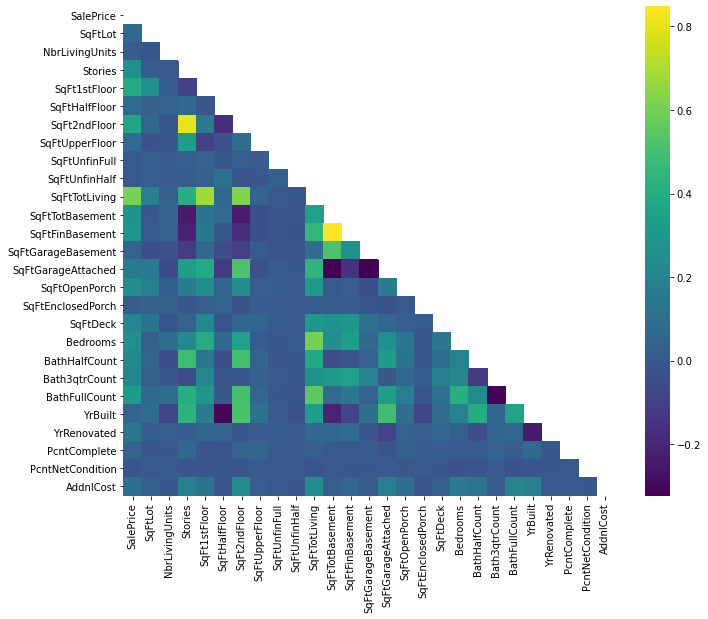

In [122]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap='viridis');

### `SqFtTotLiving` Looks Most Correlated
Confirming and printing a sorted list of correlation magnitudes

In [123]:
# creating a sorted list of correlations
np.abs(corr.SalePrice).sort_values(ascending=False).iloc[1:]

SqFtTotLiving         0.609454
SqFt1stFloor          0.392227
SqFt2ndFloor          0.370389
BathFullCount         0.318210
SqFtFinBasement       0.292734
SqFtTotBasement       0.277310
Stories               0.260426
Bedrooms              0.253457
SqFtOpenPorch         0.249485
BathHalfCount         0.225802
SqFtDeck              0.214524
Bath3qtrCount         0.209274
SqFtGarageAttached    0.156516
YrRenovated           0.136423
AddnlCost             0.097212
SqFtHalfFloor         0.080449
SqFtUpperFloor        0.076565
SqFtLot               0.074803
YrBuilt               0.051285
SqFtGarageBasement    0.049425
PcntComplete          0.039122
NbrLivingUnits        0.009062
PcntNetCondition      0.008201
SqFtEnclosedPorch     0.008199
SqFtUnfinFull         0.002262
SqFtUnfinHalf         0.000483
Name: SalePrice, dtype: float64

### Pair Plot For The Top Four Predictors

In [124]:
# collecting the top five predictors and forming data frame
li = ['SalePrice', 'SqFtTotLiving', 'SqFt1stFloor', 'SqFt2ndFloor',\
      'BathFullCount']

four_most_correlated = df[li]

In [125]:
four_most_correlated.head()

,SalePrice,SqFtTotLiving,SqFt1stFloor,SqFt2ndFloor,BathFullCount
5,560000.0,1930,1930,0,2
6,435000.0,1975,1057,918,1
94,1255000.0,2680,1760,0,1
105,380000.0,1750,920,0,1
144,930000.0,2580,1780,0,2


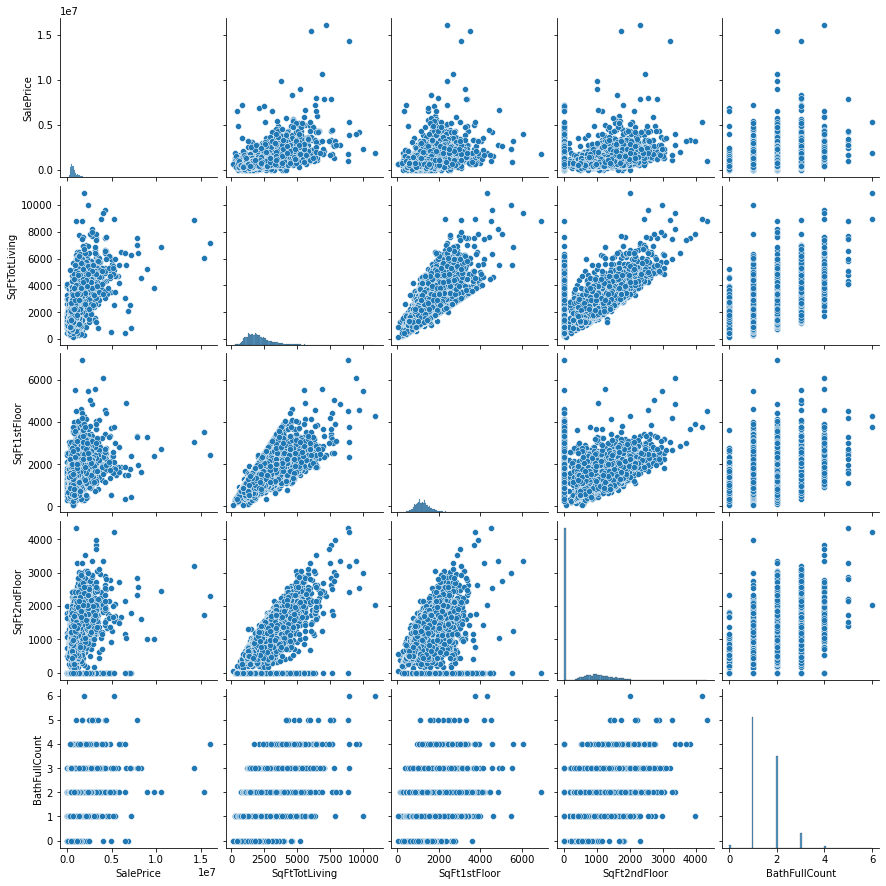

In [126]:
# printing the pairplot
sns.pairplot(four_most_correlated);

# Model 1: Baseline
Creating the first simple model using `SqFtTotLiving` as the predictor. Using alpha = .05 for all statistical tests performed throughout the modeling process.

#### Data Frame

In [127]:
fsm_df = df[['SalePrice', 'SqFtTotLiving']].copy()

#### Model

In [128]:
fsm = ols(formula="SalePrice ~ SqFtTotLiving", data=fsm_df)
fsm_results = fsm.fit()

## Model Results: R-Squared = .371

In [129]:
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     9644.
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:51:02   Log-Likelihood:            -2.3609e+05
No. Observations:               16323   AIC:                         4.722e+05
Df Residuals:                   16321   BIC:                         4.722e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.239e+04   8798.112     -1.408      0.159   -2.96e+04    4857.279
SqFtTotLiving   378.4219      3.853     98.206      0.000     370.869     385.975
==============================================================================
Omnibus:                    21907.178   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13486307.854
Skew:                           7.274   Prob(JB):                         0.00
Kurtosis:                     143.063   Cond. No.                     5.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpretation of Results
Our coefficient indicates that for every square foot increase in `SqFtTotLiving`, `SalePrice` will increase by \$378.42.

### Notes on the Results

While the coefficient of determination is decent at .37, it appears that there are some problems with the intercept. The p-value of .15, which is above our alpha of .05, means that the value is not statisitically significant, and the confidence interval given is nonsensical.

## Checking Linear Regression Assumptions

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [130]:
rainbow_statistic, rainbow_p_value = linear_rainbow(fsm_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 0.859061271344214
Rainbow p-value: 0.999999999996513


#### Result: Pass

Since the p-value was greater than .05, we fail to reject the null hypothesis and conclude that the model is linearly predicted by the feature. 

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of 0.00 indicates that the residuals are not normally distributed and that the model violates an assumption of linear regression.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the preditors.

### Error Plot

In [131]:
# getting the real and predicted sale prices
y = fsm_df['SalePrice']
y_hat = fsm_results.predict()

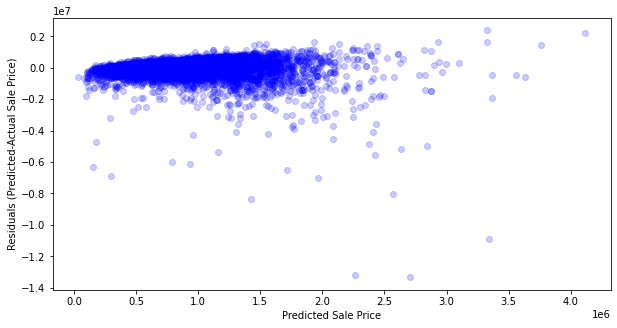

In [132]:
# plotting residuals vs predicted prices
fig, ax = plt.subplots(figsize=(10,5))
ax.set(xlabel='Predicted Sale Price',
        ylabel='Residuals (Predicted-Actual Sale Price)')
ax.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2);

#### Result: Fail

We can see from the quantity of dots well below zero, there are more extreme under-prediction than over-predictions. Further, it appears that the over-predictions increase as the predicted price increases.

### Bruesch-Pagan Test

In [133]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, fsm_df[['SqFtTotLiving']])
print('Lagrange Multiplier p-value:', lm_p_value)
print('F-statistic p-value:', f_p_value)

Lagrange Multiplier p-value: nan
F-statistic p-value: 1.2835676028594985e-74


#### Result: Fail
The p-value of 0 indicates that we must reject the null hypothesis and conclude that the variance of the target is not homogeneous across values of the predictor. This result is in line the plot of the residuals.

### Independence Check:  Variance Inflation Factor

#### Result: N/A
Skipping this for now, the model only has one predictor, so it is by independent by definition.

# Inspecting the Target and Predictor More Closely
Checking the basic stats, and visualiztions for the target and predictor.

## Basic Statistics

In [134]:
# checking statistics for sale price
print(df['SalePrice'].describe())
# checking statistics for sale price
df['SqFtTotLiving'].describe()

count    1.632300e+04
mean     7.750344e+05
std      5.836287e+05
min      1.000000e+01
25%      4.570000e+05
50%      6.458650e+05
75%      8.850000e+05
max      1.605000e+07
Name: SalePrice, dtype: float64


count    16323.000000
mean      2080.805428
std        939.941911
min        116.000000
25%       1420.000000
50%       1920.000000
75%       2530.000000
max      10910.000000
Name: SqFtTotLiving, dtype: float64

## Basic Visualizations

Checking the distribution, linearity, and outliers.

### Histograms

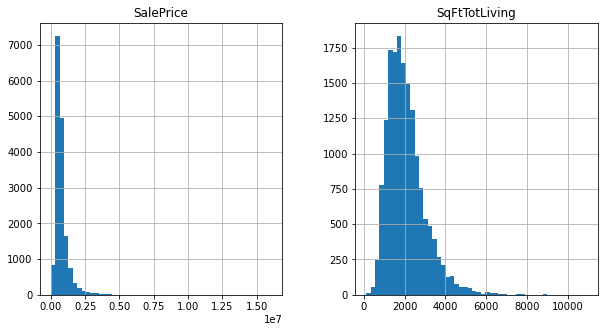

In [135]:
fsm_df.hist(bins=50, figsize=(10,5));

#### Results

Both variables have a strong rightward skew, indicating extreme outliers to the right of the distribution. Dropping outliers and/or a log transformation may be in order.

### Scatterplot

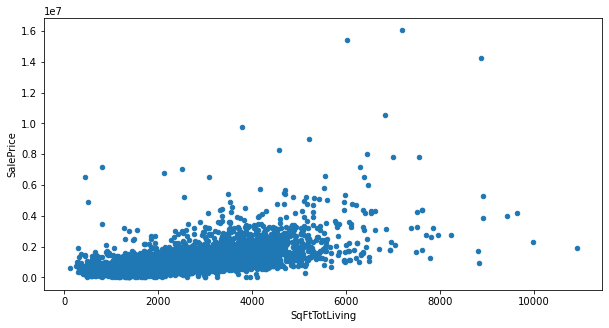

In [136]:
fsm_df.plot.scatter(x='SqFtTotLiving', y='SalePrice', figsize=(10,5));

#### Results

The data exhibits a fairly linear relationship, with the sale price generally rising with square footage. Also, observing the change in density of the data points, it appears that the vast majority of homes are below 5,500 sq. ft. 

### Boxplot

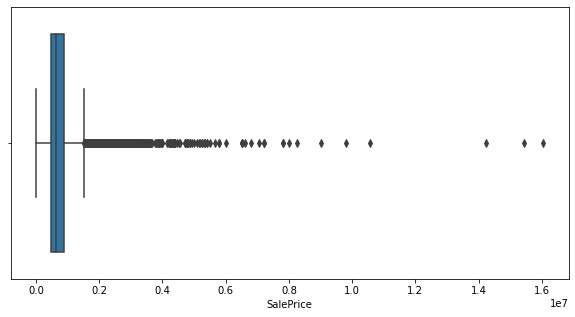

In [137]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x=df['SalePrice']);

#### Results
From the plot we can see the heavy presence of outliers on the right-hand side of the distribution.

# Removing Outliers
Checking if we can improve the coefficient of determination or the results our assumption tests by getting rid of the outliers in the data using the IQR fences method.

## Calculating Quartiles & IQR

In [138]:
# calculating Q1, Q3 and IQR
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
IQR

428000.0

## Statistics of the Outliers

In [139]:
# checking the Stats of the outliers
df[((df['SalePrice'] < (Q1 - 1.5 * IQR))\
     | (df['SalePrice'] > (Q3 + 1.5 * IQR)))]['SalePrice'].describe()

count    1.013000e+03
mean     2.377000e+06
std      1.245990e+06
min      1.530000e+06
25%      1.709000e+06
50%      1.995000e+06
75%      2.588000e+06
max      1.605000e+07
Name: SalePrice, dtype: float64

### Results

All of the outliers are on the right. The minimum value of the outliers is well above the median and mean of the model data set, which is in line with the boxplot above.

## Creating No Outliers Data Frame
Removing outliers, checking shape, and statistics.

In [140]:
no_outliers = df[~((df['SalePrice'] < (Q1 - 1.5 * IQR))\
                   | (df['SalePrice'] > (Q3 + 1.5 * IQR)))]

In [141]:
no_outliers.shape

(15310, 106)

In [142]:
no_outliers['SalePrice'].describe()

count    1.531000e+04
mean     6.690389e+05
std      2.819329e+05
min      1.000000e+01
25%      4.499500e+05
50%      6.200000e+05
75%      8.300000e+05
max      1.526000e+06
Name: SalePrice, dtype: float64

#### Results
We've lost around 1,0000 datapoints and cut out standard deviation in half.

## Visualizations

### Boxplot

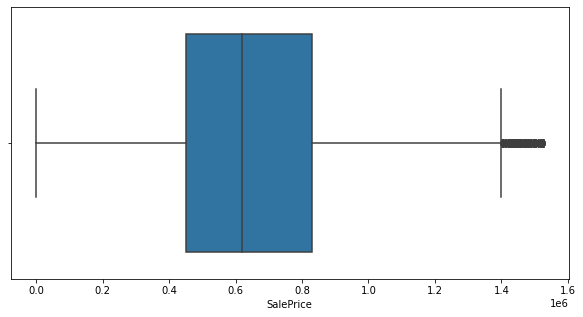

In [143]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x=no_outliers['SalePrice']);

#### Results
While there are still outliers present, the data seem to be more symmetrically distributed now.

### Histograms

#### Results
`SalePrice` is looking more normal but still has a heavier tail on the right.

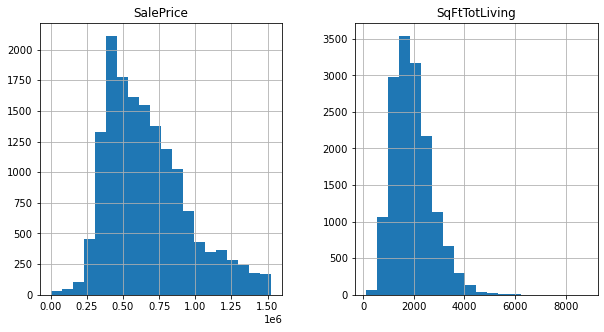

In [144]:
no_outliers[['SalePrice', 'SqFtTotLiving']].hist(bins=20, figsize=(10,5));

### Scatterpolt

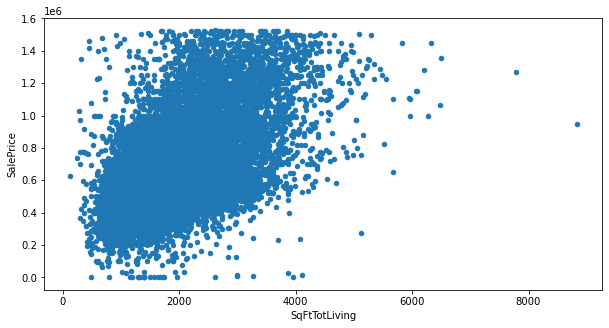

In [145]:
no_outliers[['SalePrice', 'SqFtTotLiving']].plot.scatter(x='SqFtTotLiving', y='SalePrice', figsize=(10,5));

#### Results
The linearity in the data is more pronounced now. There appears to be a cluster of very low value sales that may need to be investigatedlater in the modeling process.

# Model 2: Outliers Dropped

#### Dataframe

In [146]:
model2_df = no_outliers[['SalePrice', 'SqFtTotLiving']].copy()

#### Model

In [147]:
model2 = ols(formula="SalePrice ~ SqFtTotLiving", data=model2_df)
model2_results = model2.fit()

### Model Result: R-Squared = .293

In [148]:
model2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     6335.
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:51:04   Log-Likelihood:            -2.1120e+05
No. Observations:               15310   AIC:                         4.224e+05
Df Residuals:                   15308   BIC:                         4.224e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.854e+05   5187.217     55.017      0.000    2.75e+05    2.96e+05
SqFtTotLiving   195.4224      2.455     79.593      0.000     190.610     200.235
==============================================================================
Omnibus:                      893.680   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1094.863
Skew:                           0.588   Prob(JB):                    1.79e-238
Kurtosis:                       3.578   Cond. No.                     5.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Interpretation of Results
Our coefficient indicates that for every square foot increase in `SqFtTotLiving`, `SalePrice` will increase by \$195.42.

#### Notes of the Results
While our r-squared actually decreased from .371 to .293, the coefficients are now both statistically valid now, and the confidence intervals make sense. Dropping the outliers has improved the model overall. Still some possible numerical problems as indicated by the condition number.

## Checking Linear Regression Assumptions

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [149]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model2_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 0.9600444347813364
Rainbow p-value: 0.9627522151535642


#### Result: Pass

Since the p-value was greater than .05, we fail to reject the null hypothesis. The model is linearly predicted by the features. 

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is no longer 0.00, but it is still very small which indicates that the residuals are not normally distributed. The model stil violates an assumption of linear regression.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the preditors.

### Error Plot

In [150]:
# getting the real and predicted sale prices
y = model2_df['SalePrice']
y_hat = model2_results.predict()

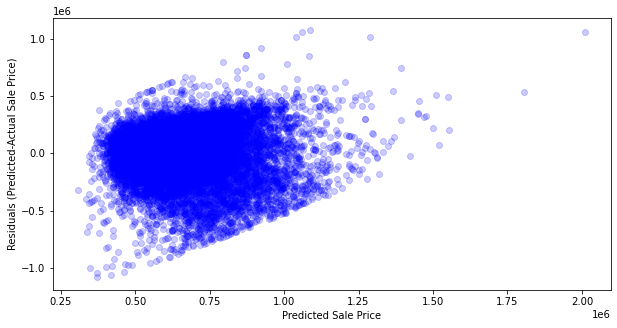

In [151]:
# plotting residuals vs predicted prices
fig, ax = plt.subplots(figsize=(10,5))
ax.set(xlabel='Predicted Sale Price',
        ylabel='Residuals (Predicted-Actual Sale Price)')
ax.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2);

#### Result: Fail
The hetroscadasicity is more pronounced in the graph, with under predictions predominating at lower predicted prices and overpredictions at higher predicted prices.

### Bruesch-Pagan Test

In [152]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, model2_df[['SqFtTotLiving']])
print('Lagrange Multiplier p-value:', lm_p_value)
print('F-statistic p-value:', f_p_value)

Lagrange Multiplier p-value: nan
F-statistic p-value: 0.0


#### Result: Fail
The p-value of 0 indicates that we must reject the null hypothesis and conclude that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

#### Result: N/A
Skipping this for now, the model only has one predictor, so it is by independent by definition.

# Model 3: Log-Transforming the Predictor
Outliers dropped before the transformation.

#### Data Frame

In [153]:
model3_df = no_outliers[['SalePrice', 'SqFtTotLiving']].copy()

#### Transform

In [154]:
model3_df['SqFtTotLiving_log'] = np.log(model3_df['SqFtTotLiving'])

In [155]:
model3_df.drop('SqFtTotLiving', axis=1, inplace=True)

In [156]:
# checking work
model3_df.head(2)

,SalePrice,SqFtTotLiving_log
5,560000.0,7.565275
6,435000.0,7.588324


#### Model

In [157]:
model3 = ols(formula="SalePrice ~ SqFtTotLiving_log", data=model3_df)
model3_results = model3.fit()

### Model Result: R-Squared = .268

In [158]:
model3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     5597.
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:51:04   Log-Likelihood:            -2.1147e+05
No. Observations:               15310   AIC:                         4.229e+05
Df Residuals:                   15308   BIC:                         4.230e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.031e+06   3.61e+04    -56.193      0.000    -2.1e+06   -1.96e+06
SqFtTotLiving_log  3.599e+05   4810.256     74.811      0.000     3.5e+05    3.69e+05
==============================================================================
Omnibus:                      987.474   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1210.670
Skew:                           0.636   Prob(JB):                    1.28e-263
Kurtosis:                       3.531   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [159]:
fn.log_interpret(model3_results, ['SqFtTotLiving_log'], .01 )

3580.72


#### Interpretation of Results
For every 1% increase in `SqFtTotLiving`, `SalePrice` will increase by \$3580.72. Since the predictor was log-transformed, an inverse-transform was applied to the coefficients to make sense of the results. 

#### Notes on the Results
While our r-squared again decreased from .293 to .268, the coefficients are statistically significant, the cofidence intervals are good and the condition number warning is gone. Logging the predictor has improved the model overall.

## Checking Linear Regression Assumptions

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [160]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model3_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 0.9673656150009675
Rainbow p-value: 0.9266488952781328


#### Result: Pass

Since the p-value was greater than .05, we fail to reject the null hypothesis. The model is linearly predicted by the feature. 

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
P-value is still close to zero,  indicating the model still violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the preditors.

### Error Plot

In [161]:
# getting the real and predicted sale prices
y = model3_df['SalePrice']
y_hat = model3_results.predict()

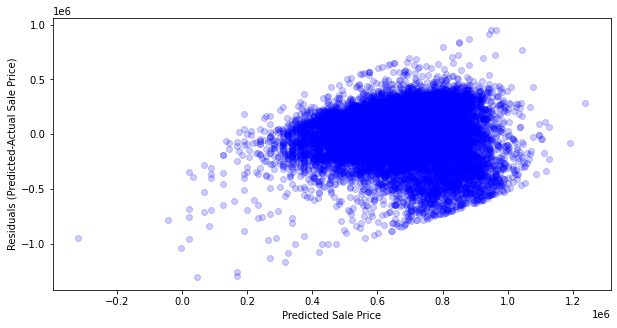

In [162]:
# plotting residuals vs predicted prices
fig, ax = plt.subplots(figsize=(10,5))
ax.set(xlabel='Predicted Sale Price',
        ylabel='Residuals (Predicted-Actual Sale Price)')
ax.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2);

#### Result: Fail
The hetroscadasicity is more pronounced in the graph, with under predictions predominating at lower predicted prices and overpredictions at higher predicted prices.

### Bruesch-Pagan Test

In [163]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, model3_df[['SqFtTotLiving_log']])
print('Lagrange Multiplier p-value:', lm_p_value)
print('F-statistic p-value:', f_p_value)

Lagrange Multiplier p-value: nan
F-statistic p-value: 0.0


#### Result: Fail
The p-value of 0 indicates that we must reject the null hypothesis and conclude that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

#### Result: N/A
Skipping this for now, the model only has one predictor, so it is by independent by definition.

## Visualizations
Checking how things have changed with logging the predictor.

### Boxplot

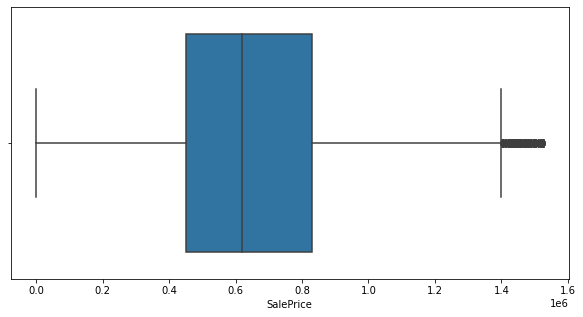

In [164]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x=model3_df['SalePrice']);

#### Results
While there are still outliers present, the data seem to be more symmetrically distributed now.

### Histograms

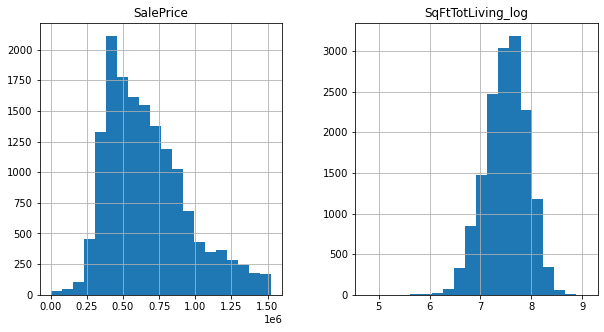

In [165]:
model3_df[['SalePrice', 'SqFtTotLiving_log']].hist(bins=20, figsize=(10,5));

#### Results
`SalePrice` is unchanged from Model 2, but `SqFtTotLiving_log` is looking more normal and now has bigger tail on the left.

### Scatterpolt

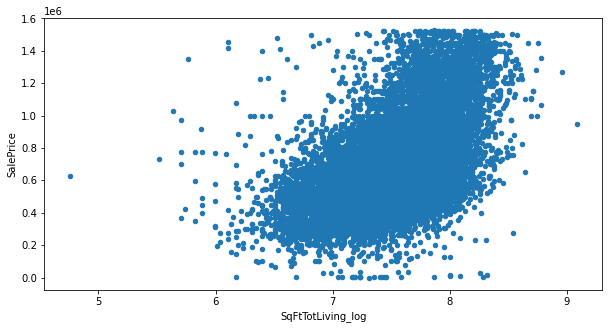

In [166]:
model3_df.plot.scatter(x='SqFtTotLiving_log', y='SalePrice', figsize=(10,5));

#### Results
The linearity in the data is still there; However, after the transformation it looks like a higher degree polynomial might be a better fit.

# Model 4: Log-Transforming the Target
Outliers still dropped before log-transformation.

#### Data Frame

In [167]:
model4_df = no_outliers[['SalePrice', 'SqFtTotLiving']].copy()

#### Log-Transform `SalePrice`

In [168]:
model4_df['SalePrice_log'] = np.log(model4_df['SalePrice'])

In [169]:
model4_df.drop('SalePrice', axis=1, inplace=True)

In [170]:
# checking work
model4_df.head(1)

,SqFtTotLiving,SalePrice_log
5,1930,13.235692


#### Model

In [171]:
model4 = ols(formula="SalePrice_log ~ SqFtTotLiving", data=model4_df)
model4_results = model4.fit()

### Model Result: R-Squared = .219

In [172]:
model4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     4295.
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:51:05   Log-Likelihood:                -8638.7
No. Observations:               15310   AIC:                         1.728e+04
Df Residuals:                   15308   BIC:                         1.730e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.7521      0.009   1370.146      0.000      12.734      12.770
SqFtTotLiving     0.0003   4.41e-06     65.536      0.000       0.000       0.000
==============================================================================
Omnibus:                    14744.256   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2683755.888
Skew:                          -4.193   Prob(JB):                         0.00
Kurtosis:                      67.318   Cond. No.                     5.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [173]:
fn.log_target(model4_results, ['SqFtTotLiving'])

0.0289


#### Interpretation of the Results
For every square foot increase in `SqFtTotLiving` the `SalePrice` will increase by .0289%.

#### Notes of the Results
R-squared decreased from .268 to .219, the coefficients and confidence intervals are still valid, but the condition number warning is back and the Jarque-Bera number has exploded. Transforming the target has reduced the quality of the model overall.

## Checking Linear Regression Assumptions

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [174]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model4_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0701535821804544
Rainbow p-value: 0.0015108441067721815


#### Result: Fail

Since the p-value is below .05, we reject the null hypothesis. The model is not linearly predicted by the features. 

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is  0.00, so the model violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the preditors.

### Error Plot

In [175]:
# getting the real and predicted sale prices
y = model4_df['SalePrice_log']
y_hat = model4_results.predict()

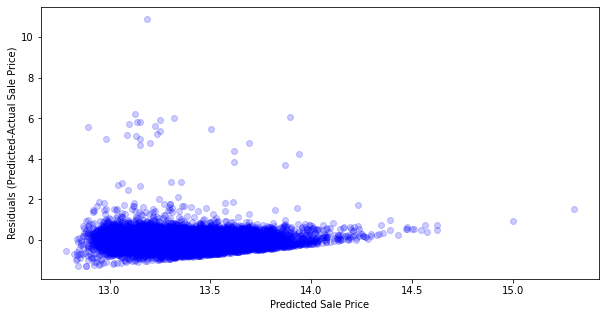

In [176]:
# plotting residuals vs predicted prices
fig, ax = plt.subplots(figsize=(10,5))
ax.set(xlabel='Predicted Sale Price',
        ylabel='Residuals (Predicted-Actual Sale Price)')
ax.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2);

#### Result: Fail
Given the wedge shape of the points, hetroscadasicity is clearly visible in the graph.

### Bruesch-Pagan Test

In [177]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, model4_df[['SqFtTotLiving']])
print('Lagrange Multiplier p-value:', lm_p_value)
print('F-statistic p-value:', f_p_value)

Lagrange Multiplier p-value: nan
F-statistic p-value: 2.39492492918432e-41


#### Result: Fail
The p-value close to 0 indicates that we must reject the null hypothesis and conclude that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

#### Result: N/A
Skipping this for now, the model only has one predictor, so it is by independent by definition.

# Model 5: Log-Transforming Both the Target and the Predictor
Outliers removed before transformation.

#### Data Frame

In [178]:
model5_df = no_outliers[['SalePrice', 'SqFtTotLiving']].copy()

#### Transformation

In [179]:
fn.logger(model5_df,['SalePrice', 'SqFtTotLiving'])

In [180]:
model5_df.drop(['SalePrice', 'SqFtTotLiving'], axis=1, inplace=True)

In [181]:
# checking results
model5_df.head(1)

,SalePrice_log,SqFtTotLiving_log
5,13.235692,7.565275


#### Model

In [182]:
model5 = ols(formula="SalePrice_log ~ SqFtTotLiving_log", data=model5_df)
model5_results = model5.fit()

### Model Result: R-Squared = .216

In [183]:
model5_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     4216.
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:51:05   Log-Likelihood:                -8669.5
No. Observations:               15310   AIC:                         1.734e+04
Df Residuals:                   15308   BIC:                         1.736e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             9.1780      0.064    143.703      0.000       9.053       9.303
SqFtTotLiving_log     0.5519      0.008     64.932      0.000       0.535       0.569
==============================================================================
Omnibus:                    14569.884   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2622347.173
Skew:                          -4.108   Prob(JB):                         0.00
Kurtosis:                      66.587   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [184]:
fn.log_all(model5_results, ['SqFtTotLiving_log'], .01)

0.5506


#### Interpreting the Results
For every 1% increase in `SqFtTotLiving` , `SalePrice` will increase by .5506%.

#### Notes of the Results
R-squared decreased slightly from .219 to .216, and the coefficients and CIs are still valid. The condition number warning number is gone again, but the Jarque_Bera number is still very large.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [185]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model5_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0761284130837812
Rainbow p-value: 0.0006660194963169775


#### Result: Fail

Failure of linearity is getting worse. P-value is much less than .05.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is  0.00, so the model still violates the normality assumption for linear regression.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the preditors.

### Error Plot

In [186]:
# getting the real and predicted sale prices
y = model5_df['SalePrice_log']
y_hat = model5_results.predict()

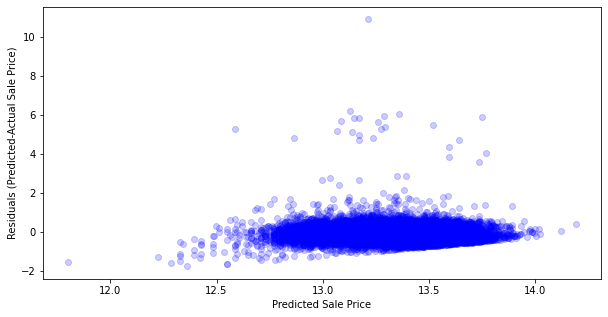

In [187]:
# plotting residuals vs predicted prices
fig, ax = plt.subplots(figsize=(10,5))
ax.set(xlabel='Predicted Sale Price',
        ylabel='Residuals (Predicted-Actual Sale Price)')
ax.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2);

#### Result: Fail
The hetroscadasicity is present in the graph, with under predictions predominating at lower predicted prices.

### Bruesch-Pagan Test

In [188]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, model5_df[['SqFtTotLiving_log']])
print('Lagrange Multiplier p-value:', lm_p_value)
print('F-statistic p-value:', f_p_value)

Lagrange Multiplier p-value: nan
F-statistic p-value: 3.8957409402003895e-51


#### Result:Fail
The p-value close to 0 indicates that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

#### Results
Skipping this for now, the model only has one predictor, so it is by independent by definition.

# Result From Initial Models: Model 3 Performed Best (R-Sq.=.268)
Will use Model 3 as the basis for moving forward. It had the best combination of r-squared and adherence to linear regression assumptions.

# Model 6: Adding `SqFt1stFloor` Feature

#### Data Frame

In [189]:
model6_df = no_outliers[['SalePrice', 'SqFtTotLiving', 'SqFt1stFloor']].copy()

#### Log Transform `SqFtTotLiving`

In [190]:
fn.logger(model6_df, ['SqFtTotLiving'])

In [191]:
model6_df.drop('SqFtTotLiving', axis=1, inplace=True)

In [192]:
# checking work
model6_df.head(1)

,SalePrice,SqFt1stFloor,SqFtTotLiving_log
5,560000.0,1930,7.565275


#### Formula

In [193]:
formula = "SalePrice ~ SqFtTotLiving_log + SqFt1stFloor"

#### Model Result: R-Squared = .270

In [194]:
model6 = ols(formula, data=model6_df)

In [195]:
model6_results = model6.fit();

In [196]:
model6_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     2828.
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:51:06   Log-Likelihood:            -2.1145e+05
No. Observations:               15310   AIC:                         4.229e+05
Df Residuals:                   15307   BIC:                         4.229e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.166e+06   4.14e+04    -52.323      0.000   -2.25e+06   -2.08e+06
SqFtTotLiving_log  3.841e+05   6030.249     63.697      0.000    3.72e+05    3.96e+05
SqFt1stFloor        -37.7852      5.680     -6.652      0.000     -48.919     -26.652
==============================================================================
Omnibus:                     1008.360   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1243.989
Skew:                           0.641   Prob(JB):                    7.43e-271
Kurtosis:                       3.552   Cond. No.                     2.83e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [197]:
fn.log_interpret(model6_results, ['SqFtTotLiving_log'], .01)

3822.03


#### Interpreting the Results
While holding `SqFt1stFloor` constant, every 1% increase in `SqFtTotLiving` will increase `SalePrice` by \$3822.03. Conversely, if `SqFtTotLiving` is held constant, for every square foot increase in `SqFt1stFloor`, `SalePrice` will decrease by \$37.79.

#### Notes of the Results
R-squared increased slightly from .268 to .270, and the coefficients and CIs are still valid. The condition number warning number is back again, and the Jarque_Bera number is still large.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [198]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model6_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 0.9651685343651406
Rainbow p-value: 0.9395110814138893


#### Result: Pass

Linearity in the model is back. The test p-value is much greater than .05.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is close to 0.00, so the model violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the preditors.

### Error Plot

In [199]:
# getting the real and predicted sale prices
y = model6_df['SalePrice']
y_hat = model6_results.predict()

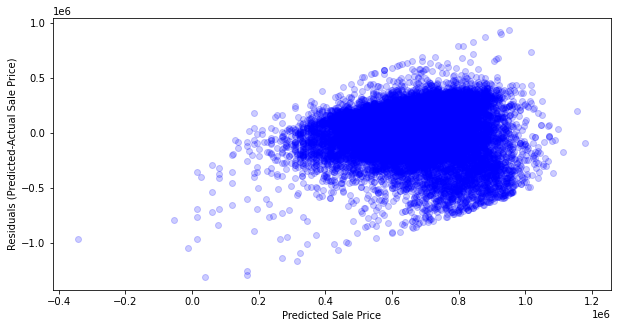

In [200]:
# plotting residuals vs predicted prices
fig, ax = plt.subplots(figsize=(10,5))
ax.set(xlabel='Predicted Sale Price',
        ylabel='Residuals (Predicted-Actual Sale Price)')
ax.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2);

#### Result: Fail
The hetroscadasicity is present in the graph, with under predictions predominating at lower predicted prices and over predictions at higher predicted prices.

### Bruesch-Pagan Test

In [201]:
cols = ['SqFtTotLiving_log', 'SqFt1stFloor']
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, model6_df[cols])
print('Lagrange Multiplier p-value:', lm_p_value)
print('F-statistic p-value:', f_p_value)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


#### Result:Fail
The p-value of 0 indicates that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

In [202]:
rows = model6_df[['SqFtTotLiving_log', 'SqFt1stFloor']].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(2)]
vif_df["feature"] = ['SqFtTotLiving_log', 'SqFt1stFloor']

vif_df

,VIF,feature
0,11.270075,SqFtTotLiving_log
1,11.270075,SqFt1stFloor


#### Result: Fail
The VIF value for both coefficients is above 10, indicating that there is strong multicollinearity in the features.

# Model 7 Log-Scaling `SqFt1stFloor` Feature

#### Data Frame

In [203]:
model7_df = no_outliers[['SalePrice', 'SqFtTotLiving', 'SqFt1stFloor']].copy()


#### Log Transform `SqFtTotLiving` & `SqFt1stFloor`

In [204]:
fn.logger(model7_df, ['SqFtTotLiving', 'SqFt1stFloor'])

In [205]:
# checking work
model7_df.drop(['SqFtTotLiving', 'SqFt1stFloor'], axis=1, inplace=True)
model7_df.head(1)

,SalePrice,SqFtTotLiving_log,SqFt1stFloor_log
5,560000.0,7.565275,7.565275


#### Formula

In [206]:
formula = "SalePrice ~ SqFtTotLiving_log + SqFt1stFloor_log"

#### Model Result: R-Squared = .276

In [207]:
model7 = ols(formula, data=model7_df)

In [208]:
model7_results = model7.fit();

In [209]:
model7_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     2920.
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:51:06   Log-Likelihood:            -2.1138e+05
No. Observations:               15310   AIC:                         4.228e+05
Df Residuals:                   15307   BIC:                         4.228e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.741e+06    4.2e+04    -41.429      0.000   -1.82e+06   -1.66e+06
SqFtTotLiving_log  4.098e+05   6072.545     67.477      0.000    3.98e+05    4.22e+05
SqFt1stFloor_log  -9.402e+04   7050.045    -13.335      0.000   -1.08e+05   -8.02e+04
==============================================================================
Omnibus:                      996.523   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1227.575
Skew:                           0.636   Prob(JB):                    2.73e-267
Kurtosis:                       3.552   Cond. No.                         226.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [210]:
fn.log_interpret(model7_results, ['SqFtTotLiving_log', 'SqFt1stFloor_log'], .01)

4077.24
-935.49


#### Interpreting the Results
While holding `SqFt1stFloor` constant, every 1% increase in `SqFtTotLiving` will increase `SalePrice` by \$4077.24. Conversely, if `SqFtTotLiving` is held constant, for every 1% increase increase in `SqFt1stFloor`, `SalePrice` will decrease by \$935.49.

#### Notes of the Results
R-squared increased slightly from .270 to .276, and the coefficients and CIs are still valid. The condition number warning number is back again, and the Jarque_Bera number is still large.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [211]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model7_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 0.9616931902969964
Rainbow p-value: 0.9562238598999079


#### Result: Pass

The test p-value is much greater than .05, so the model is linearly determined by the predictors.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is close to 0.00, so the model violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the preditors.

### Error Plot

In [212]:
# getting the real and predicted sale prices
y = model7_df['SalePrice']
y_hat = model7_results.predict()

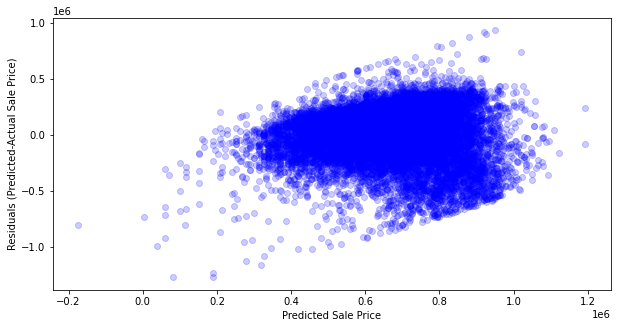

In [213]:
# plotting residuals vs predicted prices
fig, ax = plt.subplots(figsize=(10,5))
ax.set(xlabel='Predicted Sale Price',
        ylabel='Residuals (Predicted-Actual Sale Price)')
ax.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2);

#### Result: Fail
The hetroscadasicity is present in the graph, with under predictions predominating at lower predicted prices and over predictions at higher predicted prices.

### Bruesch-Pagan Test

In [214]:
cols = ['SqFtTotLiving_log', 'SqFt1stFloor_log']
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, model7_df[cols])
print('Lagrange Multiplier p-value:', lm_p_value)
print('F-statistic p-value:', f_p_value)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


#### Result:Fail
The p-value of 0 indicates that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

In [215]:
rows = model7_df[['SqFtTotLiving_log', 'SqFt1stFloor_log']].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(2)]
vif_df["feature"] = ['SqFtTotLiving_log', 'SqFt1stFloor_log']

vif_df

,VIF,feature
0,484.799614,SqFtTotLiving_log
1,484.799614,SqFt1stFloor_log


#### Result: Fail
The VIF value for both coefficients is above 10, indicating that there is strong multicollinearity in the features.

# Need To Write Up Model 8

# Model 8: Adding `BathFullCount` Feature

#### Data Frame

In [285]:
initial8 = no_outliers[['SalePrice', 'SqFtTotLiving', 'BathFullCount']].copy()

#### Log Transform `SqFtTotLiving`

In [286]:
fn.logger(initial8, ['SqFtTotLiving'])

In [287]:
initial8_logged = initial8.drop('SqFtTotLiving', axis=1)

In [288]:
# checking work
initial8_logged.head(1)

,SalePrice,BathFullCount,SqFtTotLiving_log
5,560000.0,2,7.565275


### Categorical One-Hot Encodeing

In [289]:
# instantiating, fitting and transforming
ohcoder = OneHotEncoder(drop='first')

ohcoder.fit(initial8_logged[['BathFullCount']])

transformed = ohcoder.transform(initial8_logged[['BathFullCount']])

In [290]:
# creating heat_ohe data frame and checking the first few columns
cats_ohe = pd.DataFrame(transformed.todense(),\
                       columns = ohcoder.get_feature_names())
cats_ohe.head(1)

,x0_1,x0_2,x0_3,x0_4,x0_5
0,0.0,1.0,0.0,0.0,0.0


In [291]:
dropped8 = initial8_logged.drop('BathFullCount', axis=1)

#### Creating `model8_df` Data Frame

In [292]:
# creating the model dataframe and checking first few rows
model8_df = pd.concat([dropped8, cats_ohe], axis=1)
model8_df.head(1)

,SalePrice,SqFtTotLiving_log,x0_1,x0_2,x0_3,x0_4,x0_5
0,NaN,NaN,0.0,1.0,0.0,0.0,0.0


#### Formula

In [293]:
formula = "SalePrice ~ SqFtTotLiving_log + x0_1 + x0_2 + x0_3 + x0_4 + x0_5"

#### Model Result: R-Squared = .214

In [294]:
model8 = ols(formula, data=model8_df)

In [295]:
model8_results = model8.fit();

In [296]:
model8_results.summary()

/Users/dsbox/opt/anaconda3/envs/king_co/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     50.49
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           2.42e-46
Time:                        11:27:59   Log-Likelihood:                -12896.
No. Observations:                 935   AIC:                         2.580e+04
Df Residuals:                     929   BIC:                         2.583e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.528e+06   1.66e+05     -9.230      0.000   -1.85e+06    -1.2e+06
SqFtTotLiving_log  3.053e+05   1.93e+04     15.836      0.000    2.67e+05    3.43e+05
x0_1              -9.235e+04   8.45e+04     -1.093      0.275   -2.58e+05    7.35e+04
x0_2              -9.999e+04   8.49e+04     -1.178      0.239   -2.67e+05    6.66e+04
x0_3              -1.081e+05   9.02e+04     -1.198      0.231   -2.85e+05     6.9e+04
x0_4              -1.057e+05   1.88e+05     -0.563      0.574   -4.74e+05    2.63e+05
x0_5                       0          0        nan        nan           0           0
==============================================================================
Omnibus:                       59.178   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.108
Skew:                           0.603   Prob(JB):                     3.62e-16
Kurtosis:                       3.609   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [301]:
cols = list(dropped8.columns )[1:] + list(cats_ohe.columns)

In [302]:
fn.log_interpret(model8_results, [cols], .01)

SqFtTotLiving_log    3038.17
x0_1                 -918.88
x0_2                 -994.97
x0_3                -1076.00
x0_4                -1052.09
x0_5                    0.00
dtype: float64


#### Interpreting the Results
While holding `SqFt1stFloor` constant, every 1% increase in `SqFtTotLiving` will increase `SalePrice` by \$4077.24. Conversely, if `SqFtTotLiving` is held constant, for every 1% increase increase in `SqFt1stFloor`, `SalePrice` will decrease by \935.49.

#### Notes of the Results
R-squared increased slightly from .270 to .276, and the coefficients and CIs are still valid. The condition number warning number is back again, and the Jarque_Bera number is still large.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [225]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model8_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 0.9673185268626338
Rainbow p-value: 0.9269383060220129


#### Result: Pass

The test p-value is much greater than .05, so the model is linearly determined by the predictors.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is close to 0.00, so the model violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the preditors.

### Error Plot

In [226]:
# getting the real and predicted sale prices
y = model8_df['SalePrice']
y_hat = model8_results.predict()

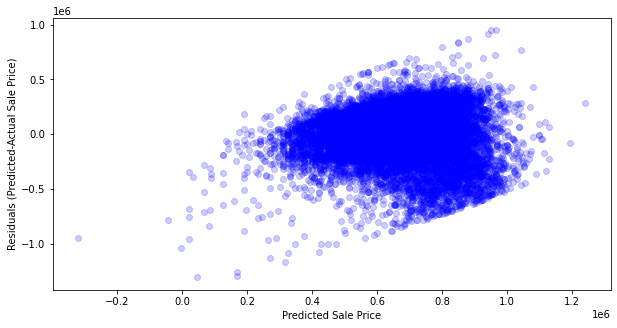

In [227]:
# plotting residuals vs predicted prices
fig, ax = plt.subplots(figsize=(10,5))
ax.set(xlabel='Predicted Sale Price',
        ylabel='Residuals (Predicted-Actual Sale Price)')
ax.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2);

#### Result: Fail
The hetroscadasicity is present in the graph, with under predictions predominating at lower predicted prices and over predictions at higher predicted prices.

### Bruesch-Pagan Test

In [228]:
cols=['SqFtTotLiving_log', 'BathFullCount']
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, model8_df[cols])
print('Lagrange Multiplier p-value:', lm_p_value)
print('F-statistic p-value:', f_p_value)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


#### Result:Fail
The p-value of 0 indicates that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

In [229]:
rows = model8_df[['SqFtTotLiving_log', 'BathFullCount']].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(2)]
vif_df["feature"] = ['SqFtTotLiving_log', 'BathFullCount']

vif_df

,VIF,feature
0,7.34416,SqFtTotLiving_log
1,7.34416,BathFullCount


#### Result: Fail
The VIF value for both coefficients is above 10, indicating that there is strong multicollinearity in the features.

# Need to Make DistrictName Values Single Strings

# Model X: Adding Categorical Feature `DistrictName` 

### Initial Data Frame

In [521]:
initialX = no_outliers[['SalePrice', 'SqFtTotLiving', 'DistrictName']].copy()

In [522]:
initialX.dropna(inplace=True)

#### Log Transformation of `SqFtTotLiving`

In [523]:
fn.logger(initialX, ['SqFtTotLiving'])

In [524]:
initialX_logged = initialX.drop('SqFtTotLiving', axis=1)

In [525]:
# checking work
initialX_logged.head(1)

,SalePrice,DistrictName,SqFtTotLiving_log
5,560000.0,DUVALL,7.565275


### Categorical One-Hot Encodeing

In [526]:
# instantiating, fitting and transforming
ohcoder = OneHotEncoder(drop='first')

ohcoder.fit(initialX_logged[['DistrictName']])

transformed = ohcoder.transform(initialX_logged[['DistrictName']])

In [527]:
# creating heat_ohe data frame and checking the first few columns
cats_ohe = pd.DataFrame(transformed.todense(),\
                       columns = ohcoder.get_feature_names())
cats_ohe.head(1)

,x0_AUBURN,x0_BEAUX ARTS,x0_BELLEVUE,x0_BLACK DIAMOND,x0_BOTHELL,x0_BURIEN,x0_CARNATION,x0_CLYDE HILL,x0_COVINGTON,x0_DES MOINES,...,x0_RENTON,x0_SAMMAMISH,x0_SEATTLE,x0_SHORELINE,x0_SKYKOMISH,x0_SNOQUALMIE,x0_SeaTac,x0_TUKWILA,x0_WOODINVILLE,x0_YARROW POINT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [528]:
droppedX = initialX_logged.drop('DistrictName', axis=1)

#### Creating `modelX_df` Data Frame

In [606]:
# creating the model dataframe and checking first few rows
modelX_df = pd.concat([droppedX, cats_ohe], axis=1)

In [607]:
modelX_df.columns = modelX_df.columns.str.replace(' ', '_')

In [608]:
modelX_df.head(3)

,SalePrice,SqFtTotLiving_log,x0_AUBURN,x0_BEAUX_ARTS,x0_BELLEVUE,x0_BLACK_DIAMOND,x0_BOTHELL,x0_BURIEN,x0_CARNATION,x0_CLYDE_HILL,...,x0_RENTON,x0_SAMMAMISH,x0_SEATTLE,x0_SHORELINE,x0_SKYKOMISH,x0_SNOQUALMIE,x0_SeaTac,x0_TUKWILA,x0_WOODINVILLE,x0_YARROW_POINT
0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [534]:
modelX_df['x0_YARROW_POINT']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
251262    NaN
251264    NaN
251274    NaN
251275    NaN
251276    NaN
Name: x0_YARROW_POINT, Length: 29685, dtype: float64

In [535]:
modelX_df.shape

(29685, 40)

#### `modelX_df` Correlation Matrix and Heatmap

In [536]:
np.abs(modelX_df.corr().SalePrice).sort_values(ascending=False).iloc[1:].dropna()

SqFtTotLiving_log      0.517420
x0_NEWCASTLE           0.075035
x0_LAKE_FOREST_PARK    0.062797
x0_MERCER_ISLAND       0.051331
x0_SHORELINE           0.050395
x0_NORTH_BEND          0.048989
x0_BLACK_DIAMOND       0.047955
x0_NORMANDY_PARK       0.046089
x0_SeaTac              0.043213
x0_FEDERAL_WAY         0.041963
x0_MILTON              0.041161
x0_KENT                0.038305
x0_KENMORE             0.033791
x0_AUBURN              0.032255
x0_CARNATION           0.027720
x0_DUVALL              0.023974
x0_RENTON              0.023459
x0_SEATTLE             0.021956
x0_KING_COUNTY         0.021128
x0_WOODINVILLE         0.020681
x0_MAPLE_VALLEY        0.019395
x0_SNOQUALMIE          0.017828
x0_SAMMAMISH           0.016044
x0_BOTHELL             0.013239
x0_BURIEN              0.012160
x0_COVINGTON           0.011048
x0_ISSAQUAH            0.010119
x0_BELLEVUE            0.007816
x0_TUKWILA             0.006056
x0_DES_MOINES          0.004406
x0_KIRKLAND            0.004158
x0_REDMO

In [539]:
corr = modelX_df.corr()

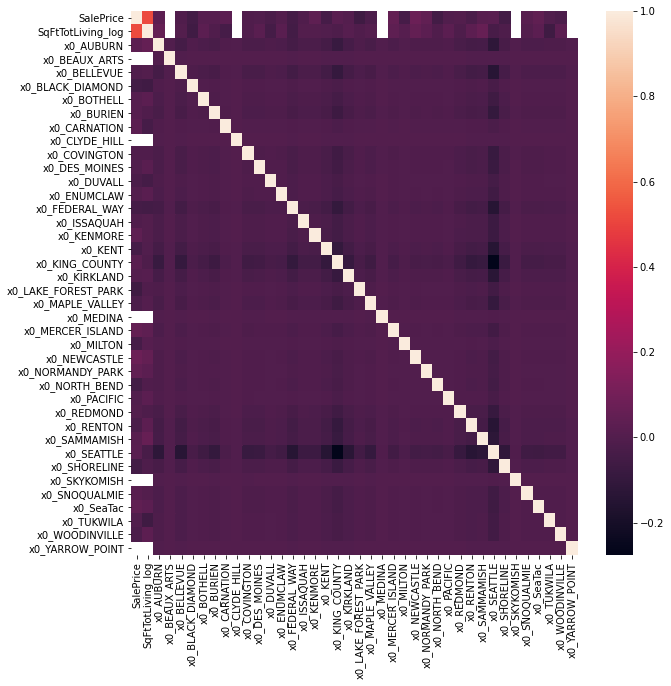

In [540]:
fig,ax = plt.subplots(figsize=(10,10))
ax=sns.heatmap(corr);

# plt.savefig('plot.png', dpi=300, bbox_inches='tight')

In [541]:
cols = list(modelX_df.columns[2:])

In [551]:
cols

['x0_AUBURN',
 'x0_BEAUX_ARTS',
 'x0_BELLEVUE',
 'x0_BLACK_DIAMOND',
 'x0_BOTHELL',
 'x0_BURIEN',
 'x0_CARNATION',
 'x0_CLYDE_HILL',
 'x0_COVINGTON',
 'x0_DES_MOINES',
 'x0_DUVALL',
 'x0_ENUMCLAW',
 'x0_FEDERAL_WAY',
 'x0_ISSAQUAH',
 'x0_KENMORE',
 'x0_KENT',
 'x0_KING_COUNTY',
 'x0_KIRKLAND',
 'x0_LAKE_FOREST_PARK',
 'x0_MAPLE_VALLEY',
 'x0_MEDINA',
 'x0_MERCER_ISLAND',
 'x0_MILTON',
 'x0_NEWCASTLE',
 'x0_NORMANDY_PARK',
 'x0_NORTH_BEND',
 'x0_PACIFIC',
 'x0_REDMOND',
 'x0_RENTON',
 'x0_SAMMAMISH',
 'x0_SEATTLE',
 'x0_SHORELINE',
 'x0_SKYKOMISH',
 'x0_SNOQUALMIE',
 'x0_SeaTac',
 'x0_TUKWILA',
 'x0_WOODINVILLE',
 'x0_YARROW_POINT']

In [546]:
formula = "SalePrice ~ SqFtTotLiving_log + x0_AUBURN + x0_BEAUX_ARTS\
+ x0_BELLEVUE + x0_BLACK_DIAMOND + x0_BOTHELL + x0_BURIEN\
+ x0_CARNATION +x0_CLYDE_HILL + x0_COVINGTON"

In [547]:
modelX = ols(formula, data=modelX_df)

In [548]:
modelX_results = modelX.fit()

In [549]:
modelX_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     31.75
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           3.13e-44
Time:                        13:49:57   Log-Likelihood:                -12895.
No. Observations:                 935   AIC:                         2.581e+04
Df Residuals:                     926   BIC:                         2.585e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -1.62e+06   1.45e+05    -11.166      0.000    -1.9e+06   -1.34e+06
SqFtTotLiving_log  3.047e+05   1.93e+04     15.766      0.000    2.67e+05    3.43e+05
x0_AUBURN          7635.6739    3.9e+04      0.196      0.845   -6.89e+04    8.42e+04
x0_BEAUX_ARTS     -1.132e-10   1.01e-10     -1.123      0.262   -3.11e-10    8.47e-11
x0_BELLEVUE       -8361.1827   3.56e+04     -0.235      0.815   -7.83e+04    6.16e+04
x0_BLACK_DIAMOND   -7.38e+04   1.07e+05     -0.692      0.489   -2.83e+05    1.36e+05
x0_BOTHELL         4113.1324    6.4e+04      0.064      0.949   -1.22e+05     1.3e+05
x0_BURIEN          3.051e+04   5.25e+04      0.581      0.561   -7.25e+04    1.34e+05
x0_CARNATION       2.182e+05   1.37e+05      1.588      0.113   -5.15e+04    4.88e+05
x0_CLYDE_HILL              0          0        nan        nan           0           0
x0_COVINGTON      -1.342e+04   7.21e+04     -0.186      0.852   -1.55e+05    1.28e+05
==============================================================================
Omnibus:                       55.881   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.658
Skew:                           0.581   Prob(JB):                     3.35e-15
Kurtosis:                       3.599   Cond. No.                     1.23e+37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.53e-70. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Model: `Forced Air Heat`

### HeatSystem Dataframe

In [552]:
heat_df = no_outliers[['SalePrice','SqFtTotLiving', 'HeatSystem']].copy()
heat_df.head(3)

,SalePrice,SqFtTotLiving,HeatSystem
5,560000.0,1930,5
6,435000.0,1975,5
94,1255000.0,2680,5


### Logging `SqFtTotLiving`

In [553]:
fn.logger(heat_df, ['SqFtTotLiving'])

In [554]:
heat_logged = heat_df.drop('SqFtTotLiving', axis=1)

In [555]:
# checking NaNs
heat_logged.head(1)

,SalePrice,HeatSystem,SqFtTotLiving_log
5,560000.0,5,7.565275


#### Prepping for Model Data Frame

Creating a dictionary of the lookup code descriptions, and using it to make a list of values for use in a new column.  Will use this column in a one-hot-encoding procedure for more descriptive column names in the model dataframe.

In [556]:
# checking unique values
print(heat_logged.HeatSystem.unique())
fn.print_uniques(heat_logged, ['HeatSystem'])

['5' '4' '1' '7' '3' '6' '2' '8' '0']
HeatSystem:  9


#### Grabbing Lookup Codes

In [557]:
# looking up HeatSystem codes 
lu_df = fn.lookup(look, 108)
lu_df

,LUType,LUItem,LUDescription
243,108,1,Floor-Wall
244,108,2,Gravity
245,108,3,Radiant
246,108,4,Elec BB
247,108,5,Forced Air
248,108,6,Hot Water
249,108,7,Heat Pump
250,108,8,Other


#### Making & Mapping Dictionary of Lookup Codes & Descriptions
Zipping lists of keys and values for dictionary from lookup data frame columns. Creating dictionary and mapping it to the `heat_df` data frame.

In [558]:
# creating heatnames dictionary
heatnames = dict(zip(lu_df.LUItem,lu_df.LUDescription))

In [559]:
heat_logged.HeatSystem.map(heatnames)

5         Forced Air
6         Forced Air
94        Forced Air
105          Elec BB
144       Forced Air
             ...    
251262    Forced Air
251264    Forced Air
251274       Elec BB
251275    Forced Air
251276    Forced Air
Name: HeatSystem, Length: 15310, dtype: object

#### Making `HeatNames` Column & Dropping `HeatSystems` From Data Frame

In [560]:
heat_logged['HeatNames'] = heat_logged.HeatSystem.map(heatnames)

In [561]:
fn.dropper(heat_logged, 'HeatSystem', True)

#### Checking for `NaN` values and replacing with `'NA'` strings.
Checking for `NaN` types. Since `NaN` values mean there was no lookup code available, replacing `NaN` values with `'NA'` strings.

In [562]:
# checking for NaNs
heat_logged['HeatNames'].isna().sum()

16

In [563]:
# filling NaNs with strings
heat_logged.fillna('NA', inplace=True)

In [564]:
# checking work
heat_logged.isna().sum()

SalePrice            0
SqFtTotLiving_log    0
HeatNames            0
dtype: int64

#### One-Hot Encoding the HeatSystem Predictor

Instantiating the encoder, fitting the encoder to `heat_df[['HeatNames']]` , and transforming the data. Creating a new `heat_ohe` data frame, dropping the `'HeatNames'` column from ` heat_df2`, and concatenating it will `heat_ohe` to form a new `model_df` data frame.

In [565]:
# # instantiating, fitting and transforming
# ohcoder = OneHotEncoder(drop='first')

# ohcoder.fit(heat_logged[['HeatNames']])

# transformed = ohcoder.transform(heat_logged[['HeatNames']])

In [493]:
# # instantiating, fitting and transforming
# ohcoder = OneHotEncoder(drop='first')

# ohcoder.fit(heat_logged[['HeatSystem']])

# transformed = ohcoder.transform(heat_logged[['HeatSystem']])

In [566]:
# creating heat_ohe data frame and checking the first few columns
heat_ohe = pd.DataFrame(transformed.todense(),\
                       columns = ohcoder.get_feature_names())
heat_ohe.head(1)

,x0_Floor-Wall,x0_Forced Air,x0_Gravity,x0_Heat Pump,x0_Hot Water,x0_NA,x0_Other,x0_Radiant
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [567]:
# dropping the 'HeatNames' column from heat_df
heat_dropped = heat_logged.drop('HeatNames', axis=1)

In [495]:
# # # dropping the 'HeatNames' column from heat_df
# heat_dropped = heat_logged.drop('HeatSystem', axis=1)

#### Creating `model_df` Data Frame

In [569]:
# creating the model dataframe and checking first few rows
modelh_df = pd.concat([heat_dropped, heat_ohe], axis=1)
modelh_df

,SalePrice,SqFtTotLiving_log,x0_Floor-Wall,x0_Forced Air,x0_Gravity,x0_Heat Pump,x0_Hot Water,x0_NA,x0_Other,x0_Radiant
0,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
251262,828130.0,7.757906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251264,395000.0,7.286192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251274,442000.0,7.265430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251275,680000.0,7.727535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [570]:
modelh_df.columns = modelh_df.columns.str.replace(' ', '_')

In [573]:
modelh_df.columns = modelh_df.columns.str.replace('-', '_')

In [574]:
modelh_df.columns

Index(['SalePrice', 'SqFtTotLiving_log', 'x0_Floor_Wall', 'x0_Forced_Air',
       'x0_Gravity', 'x0_Heat_Pump', 'x0_Hot_Water', 'x0_NA', 'x0_Other',
       'x0_Radiant'],
      dtype='object')

In [575]:
print(modelh_df.shape)
modelh_df.head(1)

(29685, 10)


,SalePrice,SqFtTotLiving_log,x0_Floor_Wall,x0_Forced_Air,x0_Gravity,x0_Heat_Pump,x0_Hot_Water,x0_NA,x0_Other,x0_Radiant
0,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### `modelh_df` Correlation Matrix and Heatmap

In [576]:
np.abs(modelh_df.corr().SalePrice).sort_values(ascending=False).iloc[1:]

SqFtTotLiving_log    0.517420
x0_Heat_Pump         0.056757
x0_Gravity           0.052675
x0_Radiant           0.027759
x0_Other             0.026376
x0_Forced_Air        0.019138
x0_Hot_Water         0.018123
x0_Floor_Wall        0.014617
x0_NA                     NaN
Name: SalePrice, dtype: float64

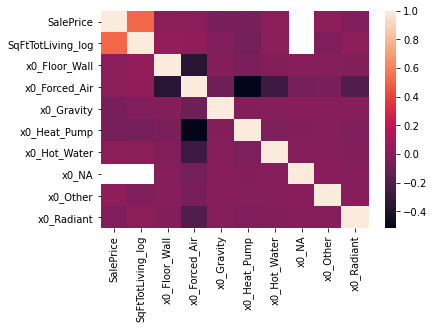

In [577]:
sns.heatmap(modelh_df.corr());

# plt.savefig('plot.png', dpi=300, bbox_inches='tight')

#### Formula

In [581]:
formula = "SalePrice ~ SqFtTotLiving_log + x0_Heat_Pump\
+ x0_Gravity + x0_Radiant + x0_Other + x0_Forced_Air\
+ x0_Hot_Water + x0_Floor_Wall+ x0_NA" 

#### Model Result: R-Squared = .214

In [582]:
modelh = ols(formula, data=modelh_df)

In [583]:
modelh_results = modelh.fit();

In [584]:
modelh_results.summary()

/Users/dsbox/opt/anaconda3/envs/king_co/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     32.40
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           4.28e-45
Time:                        14:00:32   Log-Likelihood:                -12893.
No. Observations:                 935   AIC:                         2.580e+04
Df Residuals:                     926   BIC:                         2.585e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.583e+06   1.46e+05    -10.818      0.000   -1.87e+06    -1.3e+06
SqFtTotLiving_log  3.043e+05   1.93e+04     15.789      0.000    2.66e+05    3.42e+05
x0_Heat_Pump      -6.318e+04   4.24e+04     -1.490      0.137   -1.46e+05    2.01e+04
x0_Gravity        -1.718e+05   1.09e+05     -1.569      0.117   -3.87e+05     4.3e+04
x0_Radiant        -1.137e+05   7.13e+04     -1.595      0.111   -2.54e+05    2.62e+04
x0_Other           2.811e+05   2.39e+05      1.178      0.239   -1.87e+05    7.49e+05
x0_Forced_Air     -3.234e+04   2.89e+04     -1.119      0.264   -8.91e+04    2.44e+04
x0_Hot_Water      -3628.0635   6.23e+04     -0.058      0.954   -1.26e+05    1.19e+05
x0_Floor_Wall     -3.769e+04   4.78e+04     -0.789      0.430   -1.31e+05     5.6e+04
x0_NA                      0          0        nan        nan           0           0
==============================================================================
Omnibus:                       57.766   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.191
Skew:                           0.594   Prob(JB):                     9.45e-16
Kurtosis:                       3.605   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [596]:
columns = list(modelh_df.columns )[1:]

In [597]:
fn.log_interpret(modelh_results, [columns], .01)

SqFtTotLiving_log    3027.97
x0_Floor_Wall        -375.05
x0_Forced_Air        -321.76
x0_Gravity          -1709.96
x0_Heat_Pump         -628.67
x0_Hot_Water          -36.10
x0_NA                   0.00
x0_Other             2797.34
x0_Radiant          -1131.36
dtype: float64


#### Interpreting the Results

#### Notes of the Results


### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [593]:
rainbow_statistic, rainbow_p_value = linear_rainbow(modelh_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0132049149085482
Rainbow p-value: 0.4440032033475078


#### Result: Pass

The test p-value is much greater than .05, so the model is linearly determined by the predictors.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is close to 0.00, so the model violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the preditors.

### Error Plot

In [595]:
# getting the real and predicted sale prices
y = modelh_df['SalePrice']
y_hat = modelh_results.predict()

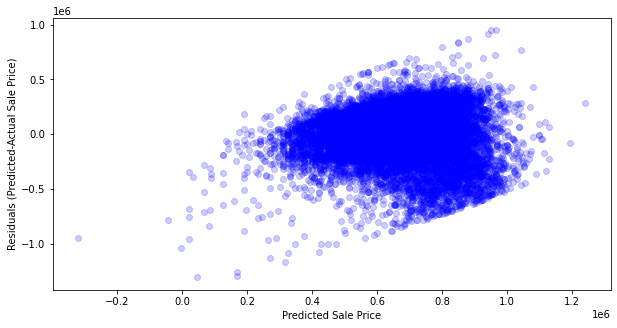

In [227]:
# plotting residuals vs predicted prices
fig, ax = plt.subplots(figsize=(10,5))
ax.set(xlabel='Predicted Sale Price',
        ylabel='Residuals (Predicted-Actual Sale Price)')
ax.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2);

#### Result: Fail
The hetroscadasicity is present in the graph, with under predictions predominating at lower predicted prices and over predictions at higher predicted prices.

### Bruesch-Pagan Test

In [600]:
columns[1:]

['x0_Floor_Wall',
 'x0_Forced_Air',
 'x0_Gravity',
 'x0_Heat_Pump',
 'x0_Hot_Water',
 'x0_NA',
 'x0_Other',
 'x0_Radiant']

In [601]:
cols=['SqFtTotLiving_log', 'x0_Floor_Wall', 'x0_Forced_Air',\
 'x0_Gravity', 'x0_Heat_Pump', 'x0_Hot_Water', 'x0_NA', 'x0_Other', 'x0_Radiant']
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, modelh_df[cols])
print('Lagrange Multiplier p-value:', lm_p_value)
print('F-statistic p-value:', f_p_value)

ValueError: operands could not be broadcast together with shapes (29685,) (935,) 

#### Result:Fail
The p-value of 0 indicates that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

In [602]:
rows = modelh_df[cols].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(2)]
vif_df["feature"] = ['SqFtTotLiving_log', 'BathFullCount']

vif_df

MissingDataError: exog contains inf or nans

#### Result: Fail
The VIF value for both coefficients is above 10, indicating that there is strong multicollinearity in the features.

#### EnclosedPoarch Dataframe

In [ ]:
# isolating SalePrice target and SqFtEnclosedPorch predictor
porch_df = df[['SqFtEnclosedPorch']]
porch_df.head()